In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image:  https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-prediction-dataset-dsn/Train Dataset .csv
/kaggle/input/heart-prediction-dataset-dsn/Test Dataset.csv
/kaggle/input/heart-prediction-dataset-dsn/Sample Submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import optuna

In [3]:
data_train = pd.read_csv('/kaggle/input/heart-prediction-dataset-dsn/Train Dataset .csv')
data_test = pd.read_csv('/kaggle/input/heart-prediction-dataset-dsn/Test Dataset.csv')
sub_sample = pd.read_csv('/kaggle/input/heart-prediction-dataset-dsn/Sample Submission.csv')

In [4]:
data_train.head(8)

Id  Age  Sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0  16167   33    0   1       158   205    1        0      154      0      1.5   
1  11275   53    1   2       198   154    0        1      104      0      0.8   
2  13251   37    1   2       101   202    1        0      155      0      2.1   
3  19921   75    0   0       113   306    1        2       88      1      4.9   
4  11293   35    1   2       139   419    1        1      166      1      0.9   
5  13835   69    1   3       164   280    0        0       88      0      5.0   
6  16226   44    0   2       134   129    0        0       71      1      5.2   
7  19944   32    1   0       164   341    1        1       93      1      5.4   

   slope  ca  thal  target  
0      1   4     1       1  
1      2   1     0       0  
2      1   3     1       1  
3      0   2     2       1  
4      2   4     0       1  
5      0   0     0       0  
6      0   3     3       1  
7      0   3     0       1

In [5]:
data_test.head()

id  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0  16501   70    1   0       163   495    0        2      170      1      2.0   
1  10444   61    1   0       131   238    0        2       74      1      4.9   
2  14288   53    1   0        95   558    1        1       73      1      0.7   
3  10409   37    0   1       178   287    0        1      192      1      5.7   
4  17330   35    0   3       104   281    0        0      122      0      1.3   

   slope  ca  thal  
0      1   0     1  
1      2   2     2  
2      1   1     0  
3      1   0     0  
4      1   4     3

In [6]:
data_test = data_test.rename(columns={'id':'Id','age':'Age', 'sex':'Sex'})
data_test.head()

Id  Age  Sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0  16501   70    1   0       163   495    0        2      170      1      2.0   
1  10444   61    1   0       131   238    0        2       74      1      4.9   
2  14288   53    1   0        95   558    1        1       73      1      0.7   
3  10409   37    0   1       178   287    0        1      192      1      5.7   
4  17330   35    0   3       104   281    0        0      122      0      1.3   

   slope  ca  thal  
0      1   0     1  
1      2   2     2  
2      1   1     0  
3      1   0     0  
4      1   4     3

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        7303 non-null   int64  
 1   Age       7303 non-null   int64  
 2   Sex       7303 non-null   int64  
 3   cp        7303 non-null   int64  
 4   trestbps  7303 non-null   int64  
 5   chol      7303 non-null   int64  
 6   fbs       7303 non-null   int64  
 7   restecg   7303 non-null   int64  
 8   thalach   7303 non-null   int64  
 9   exang     7303 non-null   int64  
 10  oldpeak   7303 non-null   float64
 11  slope     7303 non-null   int64  
 12  ca        7303 non-null   int64  
 13  thal      7303 non-null   int64  
 14  target    7303 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 855.9 KB


**Trestbps**: refers to resting blood pressure. It's a measure of the blood pressure (in mm Hg) when a person is at rest.

**Chol**: refers to serum cholesterol levels (in mg/dL), specifically the total cholesterol in the blood.Total cholesterol levels under 200 mg/dL are generally considered desirable. Levels between 200-239 mg/dL are borderline high, and 240 mg/dL or more is considered high.

**Thalach**: refers to maximum heart rate achieved during exercise stress testing, and it is measured in beats per minute (bpm). It is an important indicator used in assessing cardiovascular fitness and predicting heart disease.

**oldpeak**: Oldpeak is a measure of how much the ST segment on an electrocardiogram (ECG) is below the baseline when someone is exercising. It's like a way to see how your heart is doing when you exercise. Higher oldpeak values mean there might be more significant problems with the heart’s ability to get enough blood. Lower oldpeak values are generally better, indicating healthier heart function during exercise.

**cp**: stands for chest pain type, which is used to classify different kinds of chest pain a person might feel. 

There are typically four types of chest pain (cp):

Typical Angina: Pain related to the heart, often triggered by exercise or stress.
Atypical Angina: Chest pain that’s not as clearly related to heart issues.
Non-Anginal Pain: Pain that doesn’t seem to come from the heart, like from muscles or bones.
Asymptomatic: No chest pain at all.

0: Typical angina
1: Atypical angina
2: Non-anginal pain
3: Asymptomatic

**fbs**: stands for fasting blood sugar, which measures the level of sugar (glucose) in your blood after you haven’t eaten for at least 8 hours. It's usually given in mg/dL.
Fbs > 120 mg/dL is considered high and may indicate diabetes, which is a risk factor for heart disease. Fbs ≤ 120 mg/dL is generally considered normal. Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false)

**restecg**: stands for resting electrocardiogram results, which shows how the heart is functioning when a person is at rest. It records the electrical activity of the heart and helps detect any heart problems.
0: Normal
1: Having ST-T wave abnormality
2: Showing probable or definite left ventricular hypertrophy

**exang**: stands for exercise-induced angina, which is chest pain that occurs during physical activity. It helps doctors determine if someone's heart struggles when they exercise.
Exang = 1 means the person experiences chest pain during exercise (positive for exercise-induced angina).
Exang = 0 means the person does not experience chest pain during exercise (negative for exercise-induced angina).

**slope**: refers to the slope of the ST segment during exercise on an electrocardiogram (ECG). unsloping=0, flat=1, downsloping= 2

**ca**: stands for number of major vessels colored by fluoroscopy. It indicates how many major blood vessels in the heart have blockages that can be seen in imaging tests.

Ca = 0: No major vessels show blockages.
Ca = 1: One major vessel shows a blockage.
Ca = 2: Two major vessels show blockages.
Ca = 3: Three major vessels show blockages.

**thal**: refers to thallium stress test results, which are used to assess how well blood flows to the heart muscle during stress (like exercise) and at rest. The test uses a radioactive substance (thallium) to help visualize blood flow.
The thal results are usually classified into three categories:
Normal (0): Blood flow to the heart muscle is normal during both rest and exercise.
Fixed Defect (1): There is a consistent area of reduced blood flow during both rest and exercise, indicating potential scarring or damage to the heart muscle.
Reversible Defect (2): Blood flow is reduced during exercise but normal at rest, which may indicate that there are blockages that limit blood flow only during increased heart activity.
Not described (3)


**Age**: Age of the patient 

**Sex**: Patient Gender 
Female = 0
Male = 1

In [8]:
data_train.describe().T

count          mean          std      min      25%      50%  \
Id        7303.0  15021.535396  2886.026080  10001.0  12521.5  15054.0   
Age       7303.0     53.172669    14.185970     29.0     41.0     53.0   
Sex       7303.0      0.499658     0.500034      0.0      0.0      0.0   
cp        7303.0      1.502533     1.115594      0.0      1.0      1.0   
trestbps  7303.0    147.447487    31.099538     94.0    120.0    148.0   
chol      7303.0    342.805970   127.291998    126.0    231.0    341.0   
fbs       7303.0      0.493085     0.499986      0.0      0.0      0.0   
restecg   7303.0      1.013008     0.815806      0.0      0.0      1.0   
thalach   7303.0    136.506093    38.141966     71.0    104.0    137.0   
exang     7303.0      0.503218     0.500024      0.0      0.0      1.0   
oldpeak   7303.0      3.129851     1.791160      0.0      1.6      3.1   
slope     7303.0      0.991510     0.817291      0.0      0.0      1.0   
ca        7303.0      2.019033     1.410546      0.0      1.0      2.0   
thal      7303.0      1.502259     1.113137      0.0      1.0      1.0   
target    7303.0      0.813501     0.389535      0.0      1.0      1.0   

              75%      max  
Id        17513.5  19998.0  
Age          65.0     77.0  
Sex           1.0      1.0  
cp            3.0      3.0  
trestbps    174.0    200.0  
chol        450.0    564.0  
fbs           1.0      1.0  
restecg       2.0      2.0  
thalach     170.0    202.0  
exang         1.0      1.0  
oldpeak       4.7      6.2  
slope         2.0      2.0  
ca            3.0      4.0  
thal          2.0      3.0  
target        1.0      1.0

In [9]:
continuous_features = ['Age','trestbps','chol','thalach','oldpeak']
categorical_features = ['Sex','cp','fbs','restecg','exang','slope','ca','thal','target']

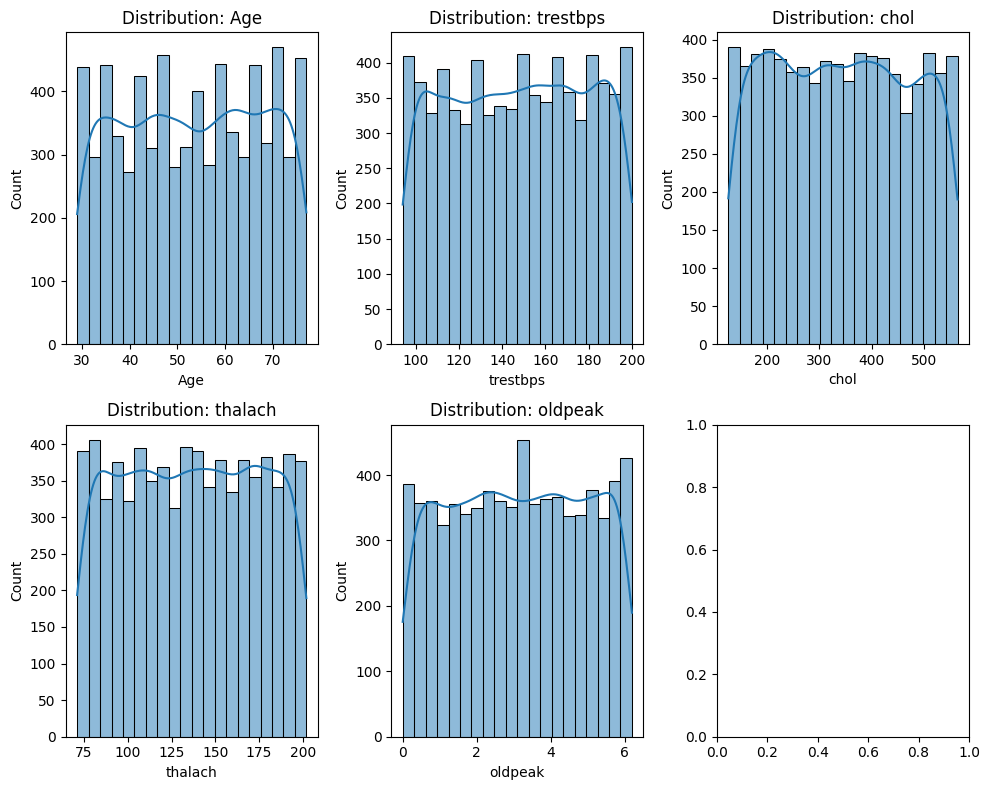

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  

sns.histplot(data_train['Age'], kde=True, ax=axes[0,0])
axes[0,0].set_xlabel('Age')
axes[0,0].set_title('Distribution: Age')

sns.histplot(data_train['trestbps'], kde=True, ax=axes[0,1])
axes[0,1].set_xlabel('trestbps')
axes[0,1].set_title('Distribution: trestbps')

sns.histplot(data_train['chol'], kde=True, ax=axes[0,2])
axes[0,2].set_xlabel('chol')
axes[0,2].set_title('Distribution: chol')

sns.histplot(data_train['thalach'], kde=True, ax=axes[1,0])
axes[1,0].set_xlabel('thalach')
axes[1,0].set_title('Distribution: thalach')

sns.histplot(data_train['oldpeak'], kde=True, ax=axes[1,1])
axes[1,1].set_xlabel('oldpeak')
axes[1,1].set_title('Distribution: oldpeak')

plt.tight_layout()  
plt.show()


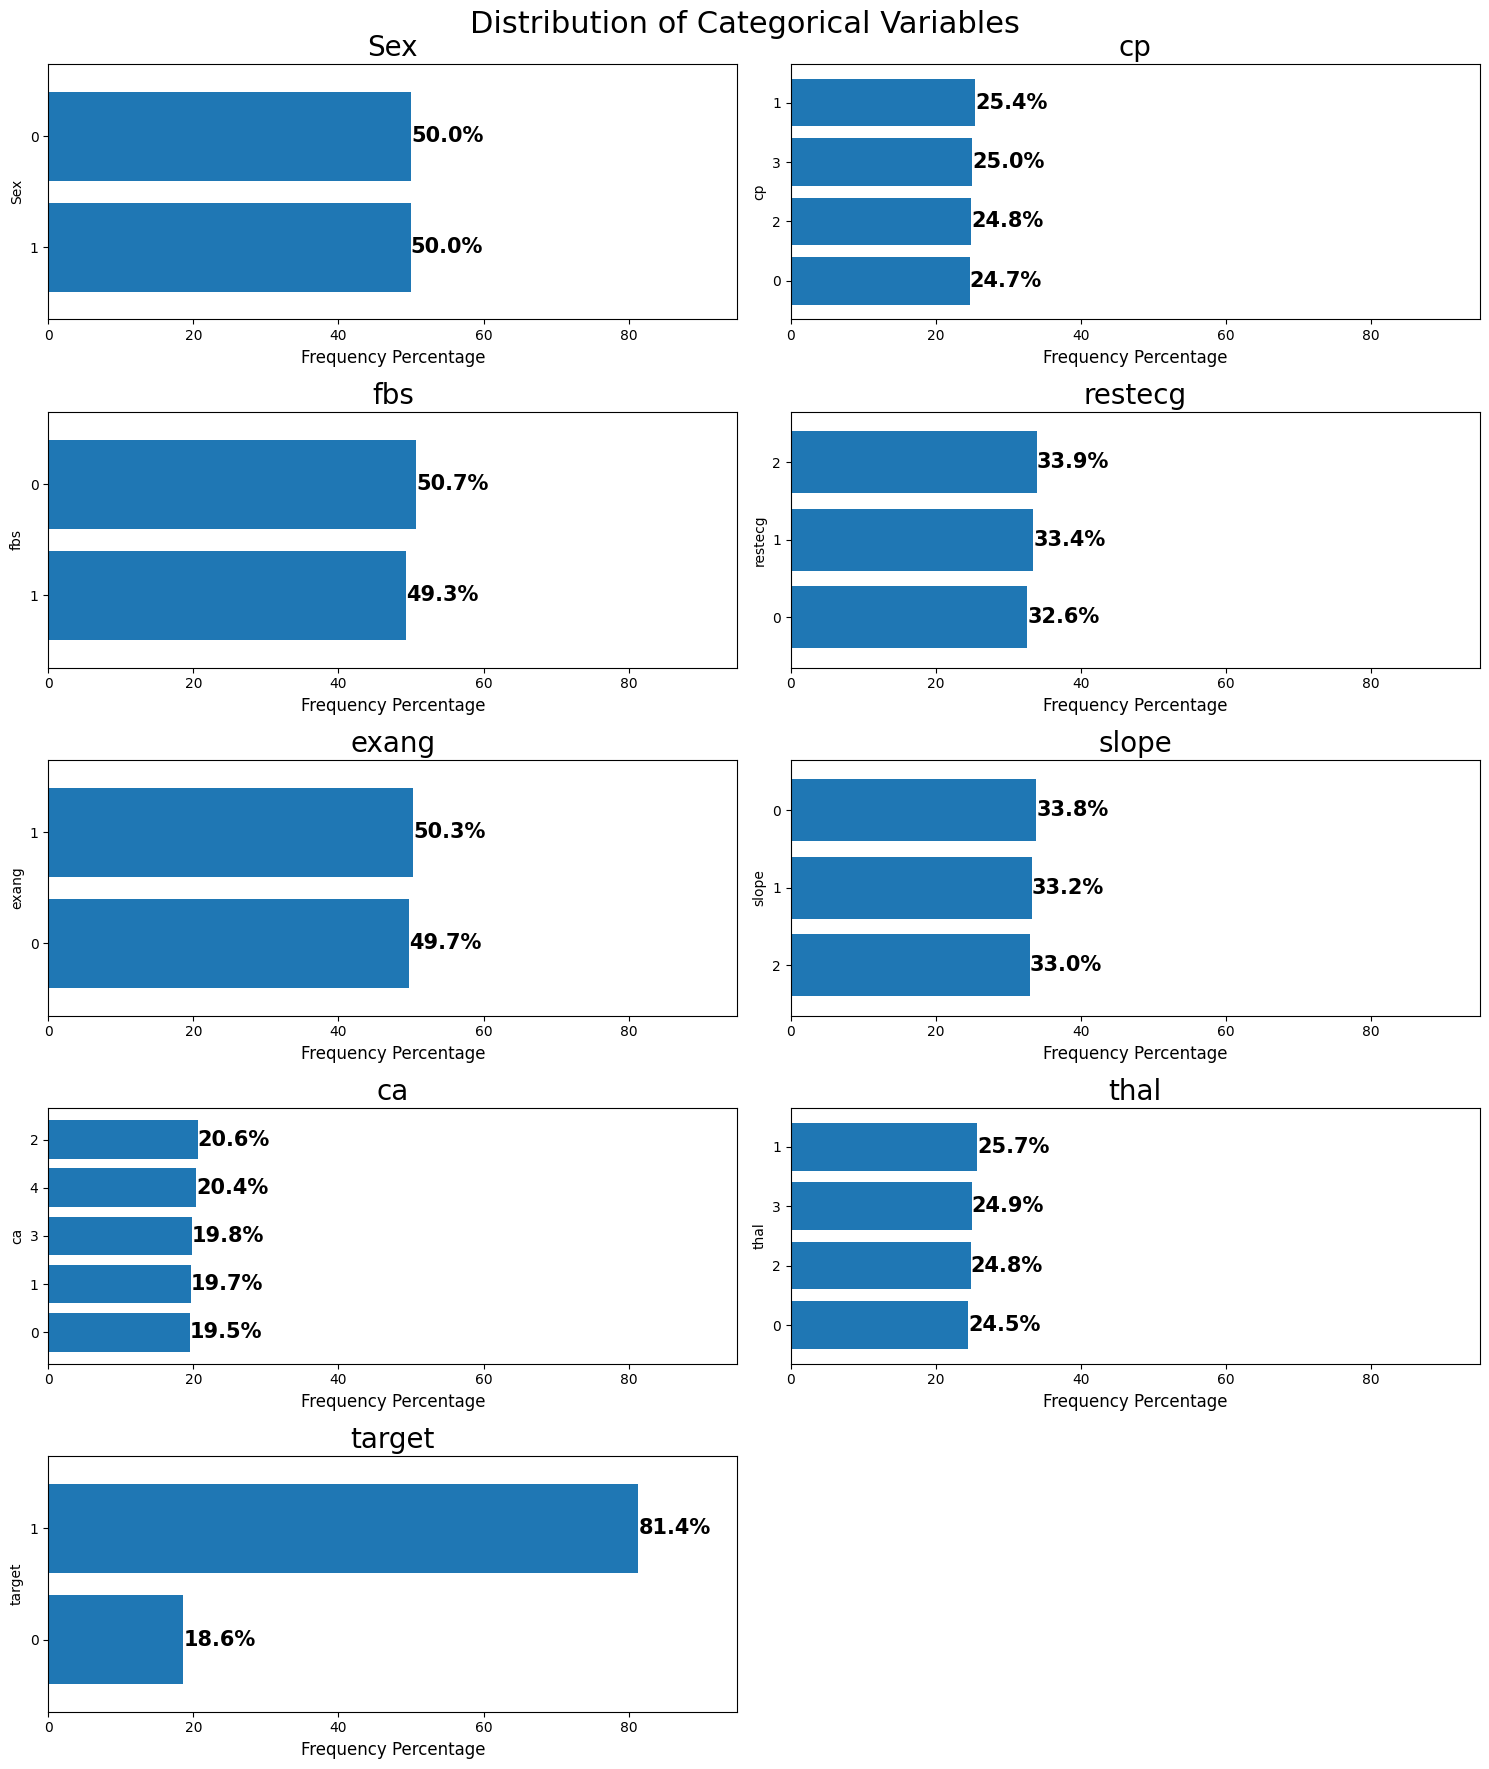

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = data_train[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8)
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

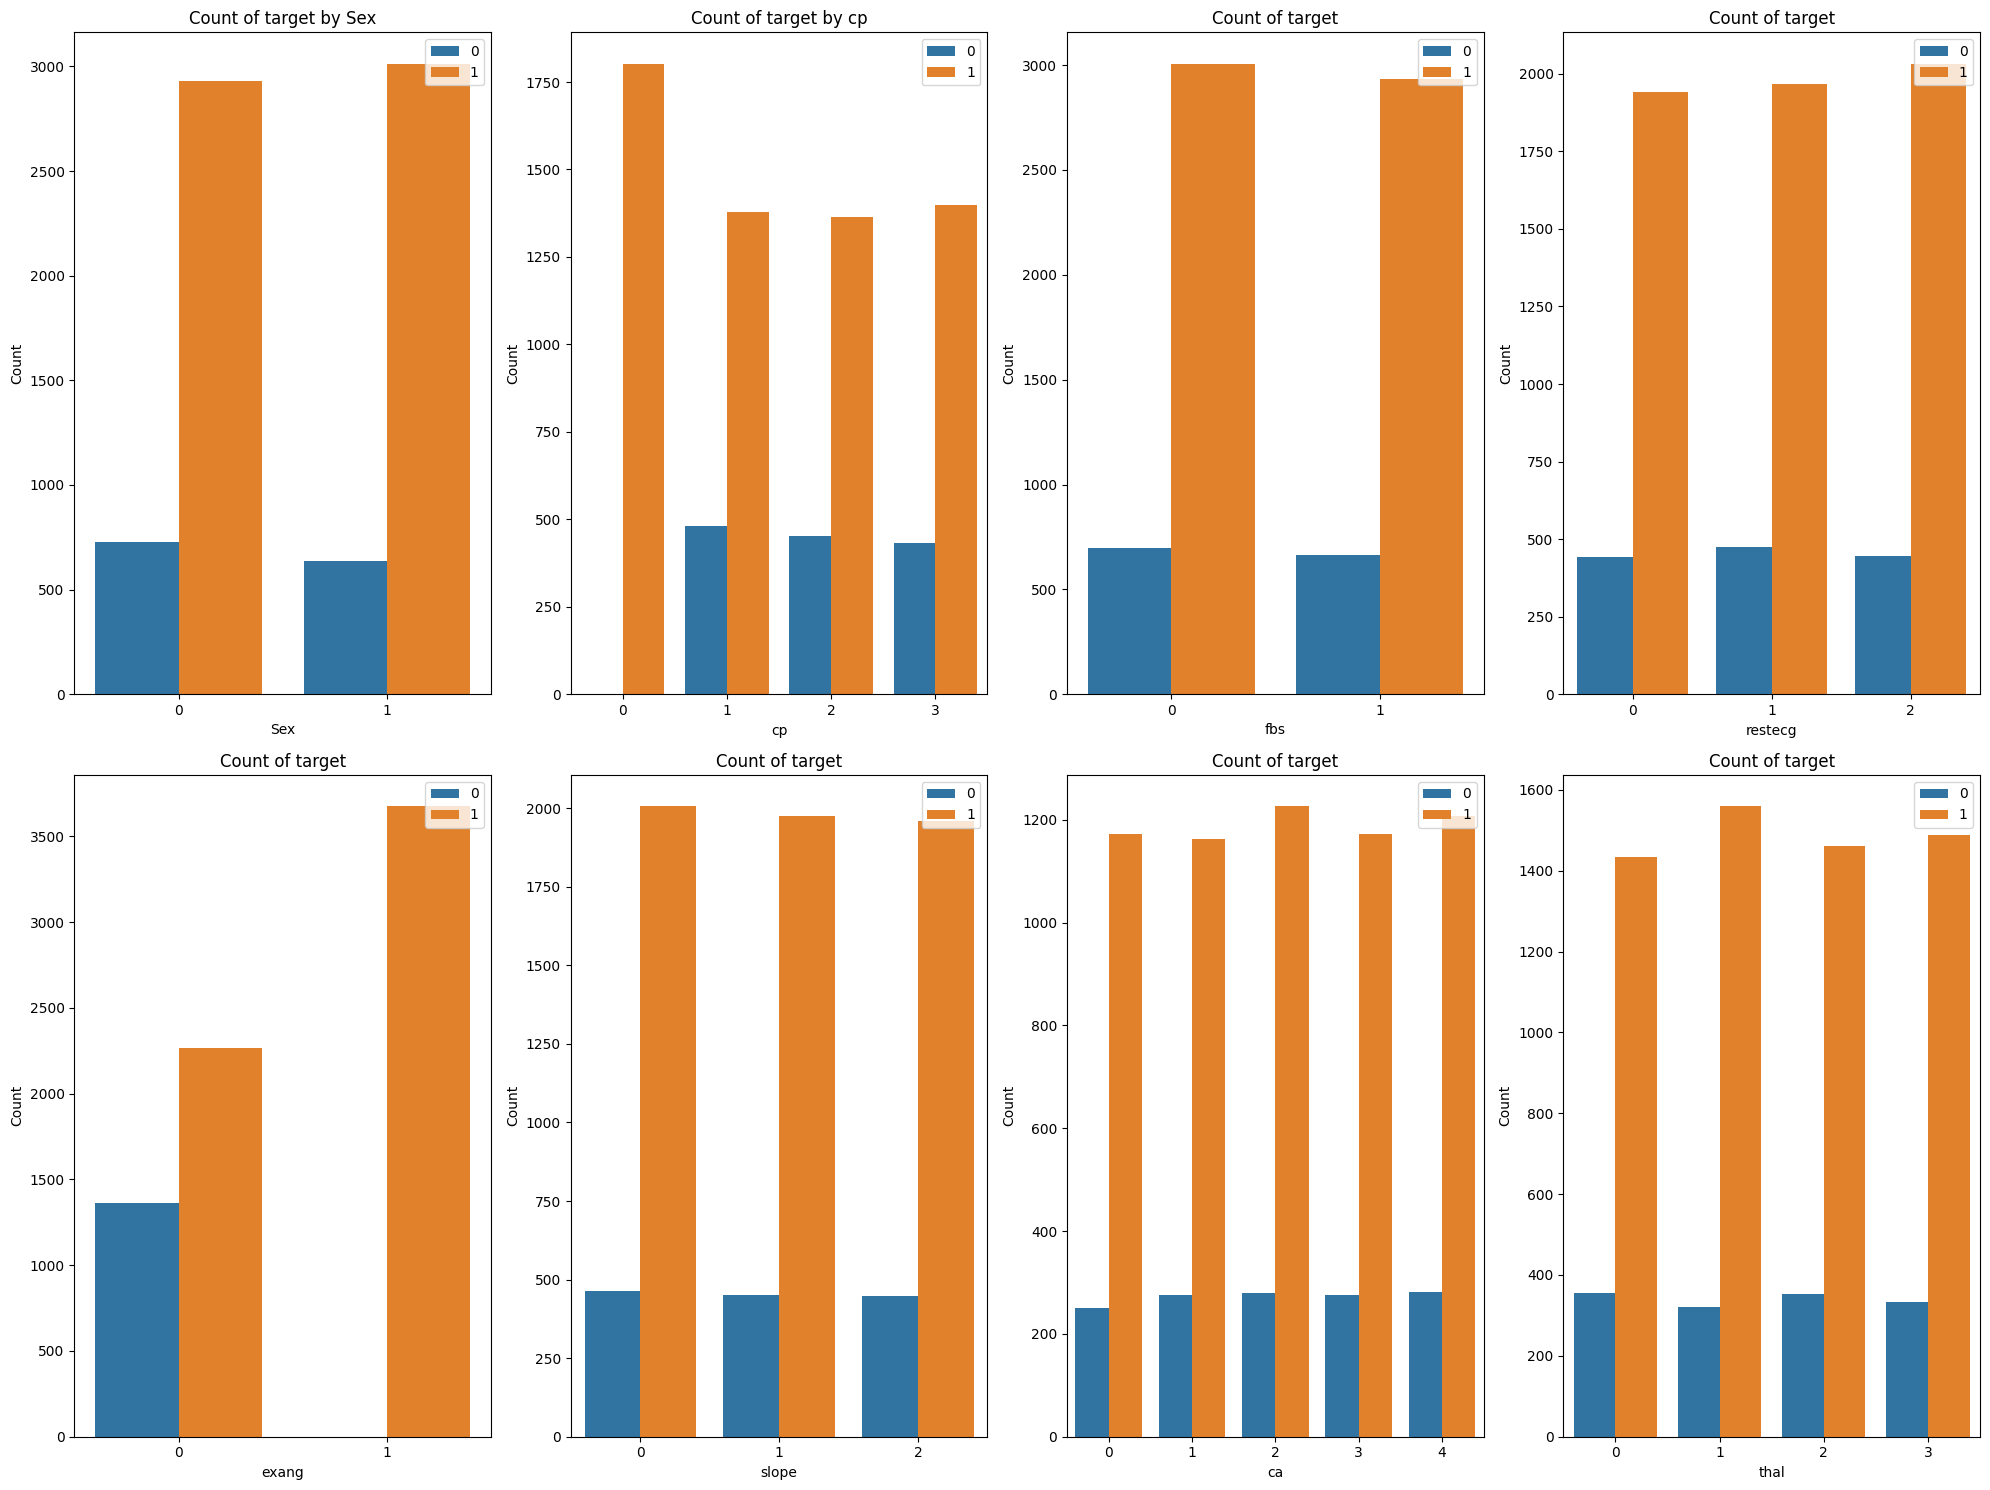

In [12]:
fig, axes = plt.subplots(2,4, figsize=(20,15))

sns.countplot(x='Sex', hue='target', data=data_train, ax=axes[0,0])
axes[0,0].set_xlabel('Sex')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Count of target by Sex')
axes[0,0].legend(loc='upper right', labels=['0','1'])

sns.countplot(x='cp', hue='target', data=data_train, ax=axes[0,1])
axes[0,1].set_xlabel('cp')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Count of target by cp')
axes[0,1].legend(loc='upper right', labels=['0','1'])

sns.countplot(x='fbs', hue='target', data=data_train, ax=axes[0,2])
axes[0,2].set_xlabel('fbs')
axes[0,2].set_ylabel('Count')
axes[0,2].set_title('Count of target')
axes[0,2].legend(loc='upper right', labels=['0','1'])

sns.countplot(x='restecg', hue='target', data=data_train, ax=axes[0,3])
axes[0,3].set_xlabel('restecg')
axes[0,3].set_ylabel('Count')
axes[0,3].set_title('Count of target')
axes[0,3].legend(loc='upper right', labels=['0','1'])


sns.countplot(x='exang', hue='target', data=data_train, ax=axes[1,0])
axes[1,0].set_xlabel('exang')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Count of target')
axes[1,0].legend(loc='upper right', labels=['0','1'])

sns.countplot(x='slope', hue='target', data=data_train, ax=axes[1,1])
axes[1,1].set_xlabel('slope')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Count of target')
axes[1,1].legend(loc='upper right', labels=['0','1'])

sns.countplot(x='ca', hue='target', data=data_train, ax=axes[1,2])
axes[1,2].set_xlabel('ca')
axes[1,2].set_ylabel('Count')
axes[1,2].set_title('Count of target')
axes[1,2].legend(loc='upper right', labels=['0','1'])

sns.countplot(x='thal', hue='target', data=data_train, ax=axes[1,3])
axes[1,3].set_xlabel('thal')
axes[1,3].set_ylabel('Count')
axes[1,3].set_title('Count of target')
axes[1,3].legend(loc='upper right', labels=['0','1'])

plt.tight_layout()

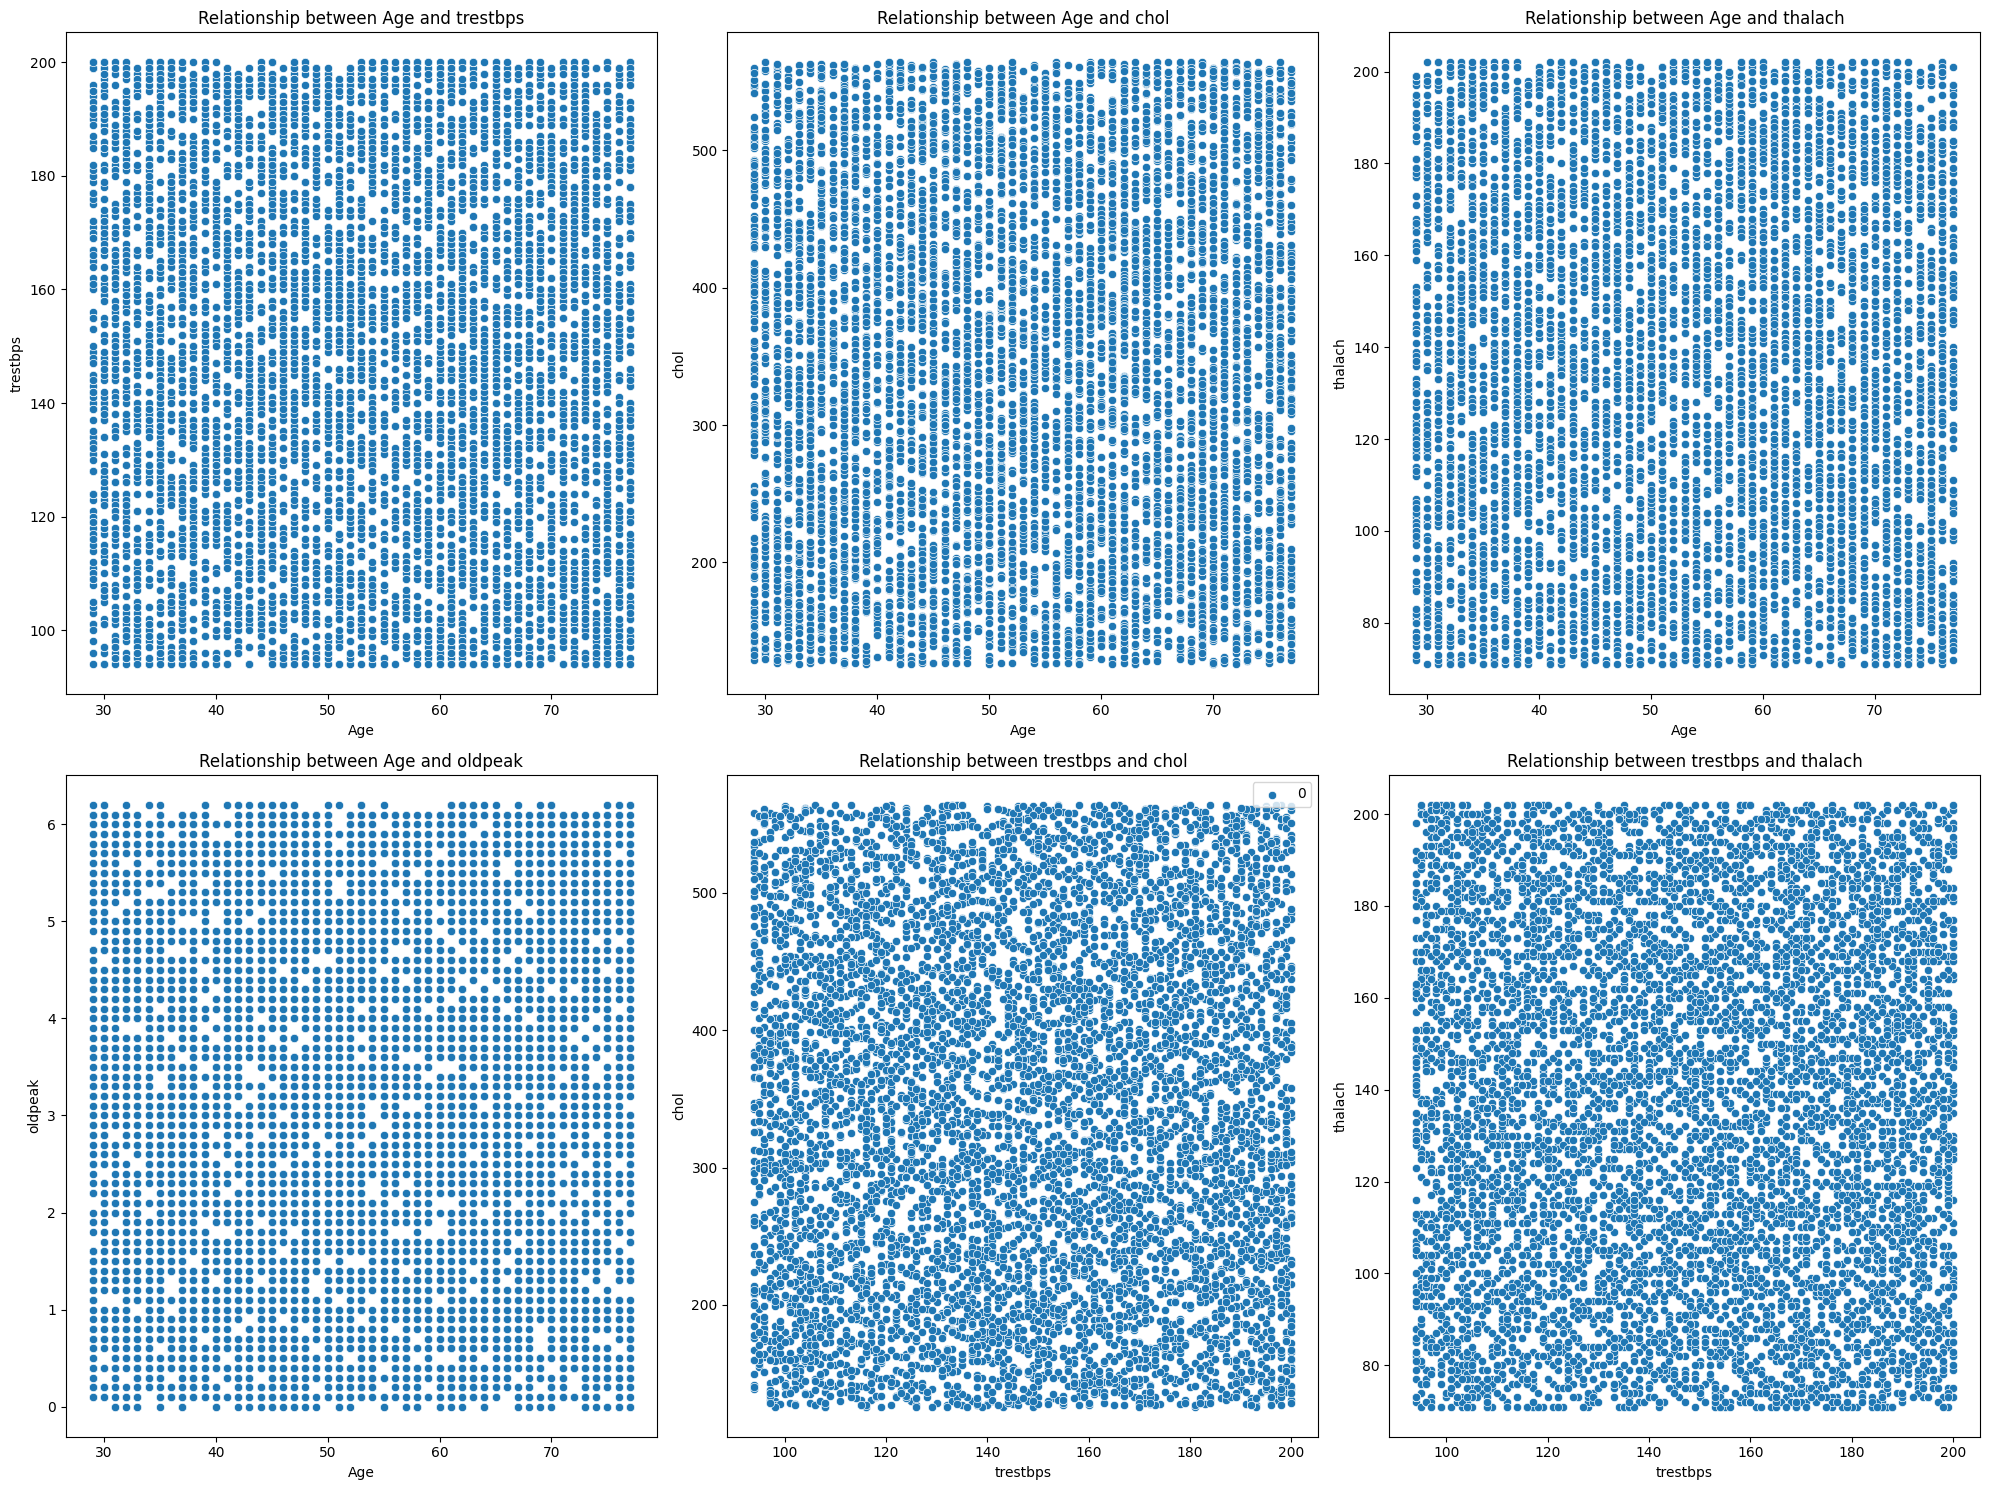

In [13]:
fig, axes = plt.subplots(2,3, figsize=(20,15))

sns.scatterplot(x='Age', y='trestbps', data=data_train, ax=axes[0,0])
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('trestbps')
axes[0,0].set_title('Relationship between Age and trestbps')

sns.scatterplot(x='Age', y='chol', data=data_train, ax=axes[0,1])
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('chol')
axes[0,1].set_title('Relationship between Age and chol')

sns.scatterplot(x='Age', y='thalach', data=data_train, ax=axes[0,2])
axes[0,2].set_xlabel('Age')
axes[0,2].set_ylabel('thalach')
axes[0,2].set_title('Relationship between Age and thalach')


sns.scatterplot(x='Age', y='oldpeak', data=data_train, ax=axes[1,0])
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('oldpeak')
axes[1,0].set_title('Relationship between Age and oldpeak')

sns.scatterplot(x='trestbps', y='chol', data=data_train, ax=axes[1,1])
axes[1,1].set_xlabel('trestbps')
axes[1,1].set_ylabel('chol')
axes[1,1].set_title('Relationship between trestbps and chol')
axes[1,1].legend(loc='upper right', labels=['0','1'])

sns.scatterplot(x='trestbps', y='thalach', data=data_train, ax=axes[1,2])
axes[1,2].set_xlabel('trestbps')
axes[1,2].set_ylabel('thalach')
axes[1,2].set_title('Relationship between trestbps and thalach')


plt.tight_layout()

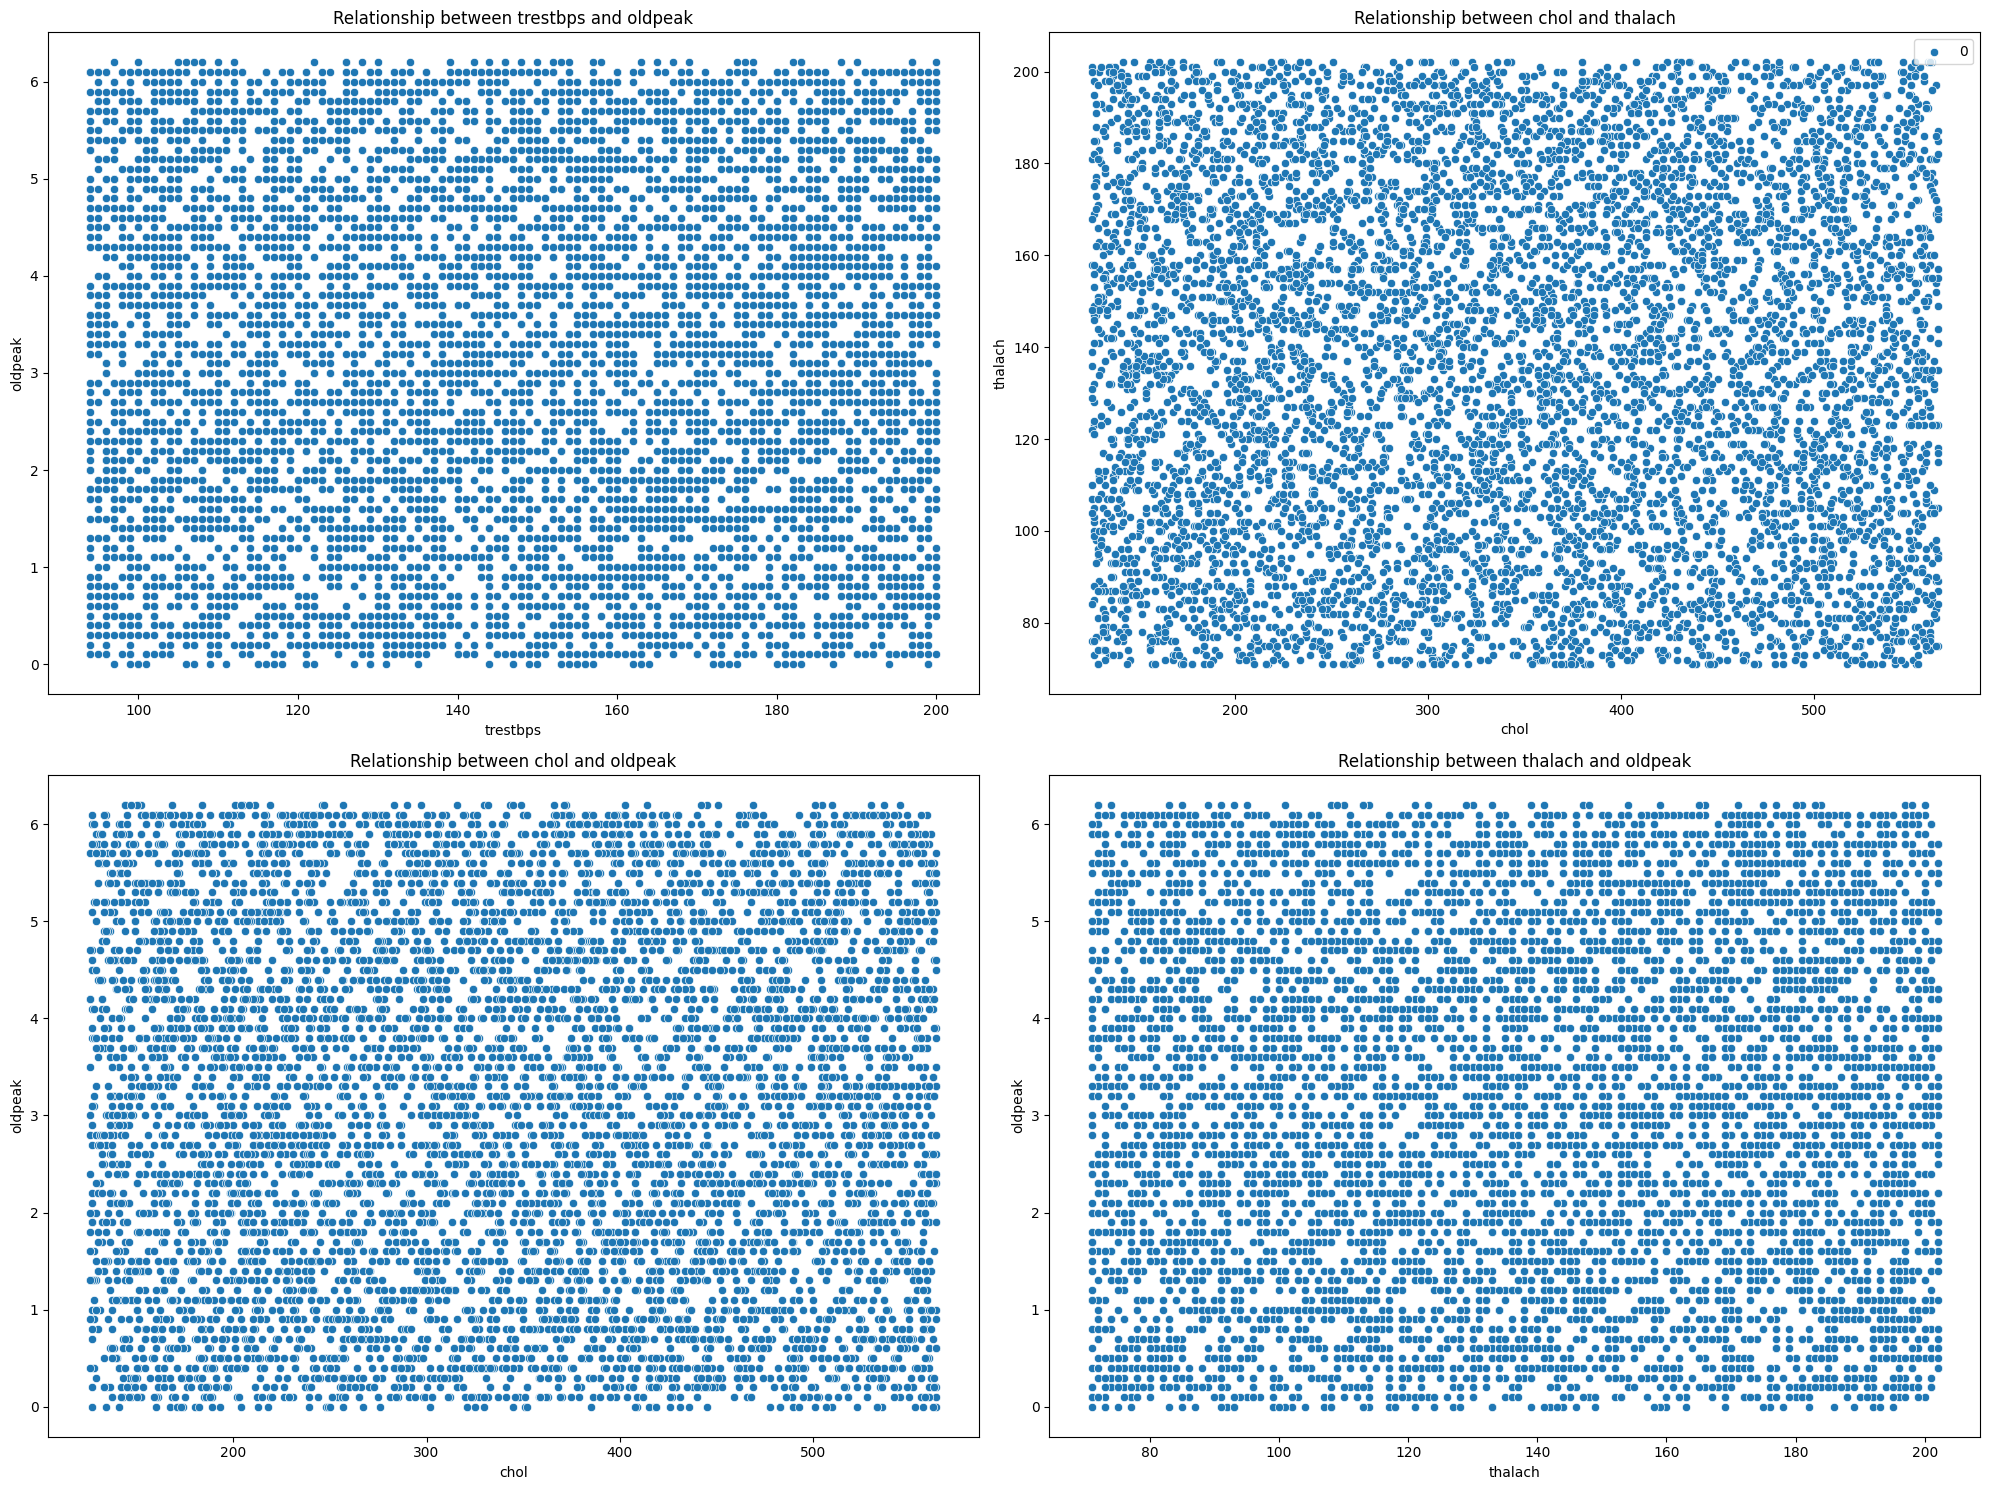

In [14]:
fig, axes = plt.subplots(2,2, figsize=(20,15))

sns.scatterplot(x='trestbps', y='oldpeak', data=data_train, ax=axes[0,0])
axes[0,0].set_xlabel('trestbps')
axes[0,0].set_ylabel('oldpeak')
axes[0,0].set_title('Relationship between trestbps and oldpeak')

sns.scatterplot(x='chol', y='thalach', data=data_train, ax=axes[0,1])
axes[0,1].set_xlabel('chol')
axes[0,1].set_ylabel('thalach')
axes[0,1].set_title('Relationship between chol and thalach')
axes[0,1].legend(loc='upper right', labels=['0','1'])

sns.scatterplot(x='chol', y='oldpeak', data=data_train, ax=axes[1,0])
axes[1,0].set_xlabel('chol')
axes[1,0].set_ylabel('oldpeak')
axes[1,0].set_title('Relationship between chol and oldpeak')

sns.scatterplot(x='thalach', y='oldpeak', data=data_train, ax=axes[1,1])
axes[1,1].set_xlabel('thalach')
axes[1,1].set_ylabel('oldpeak')
axes[1,1].set_title('Relationship between thalach and oldpeak')

plt.tight_layout()

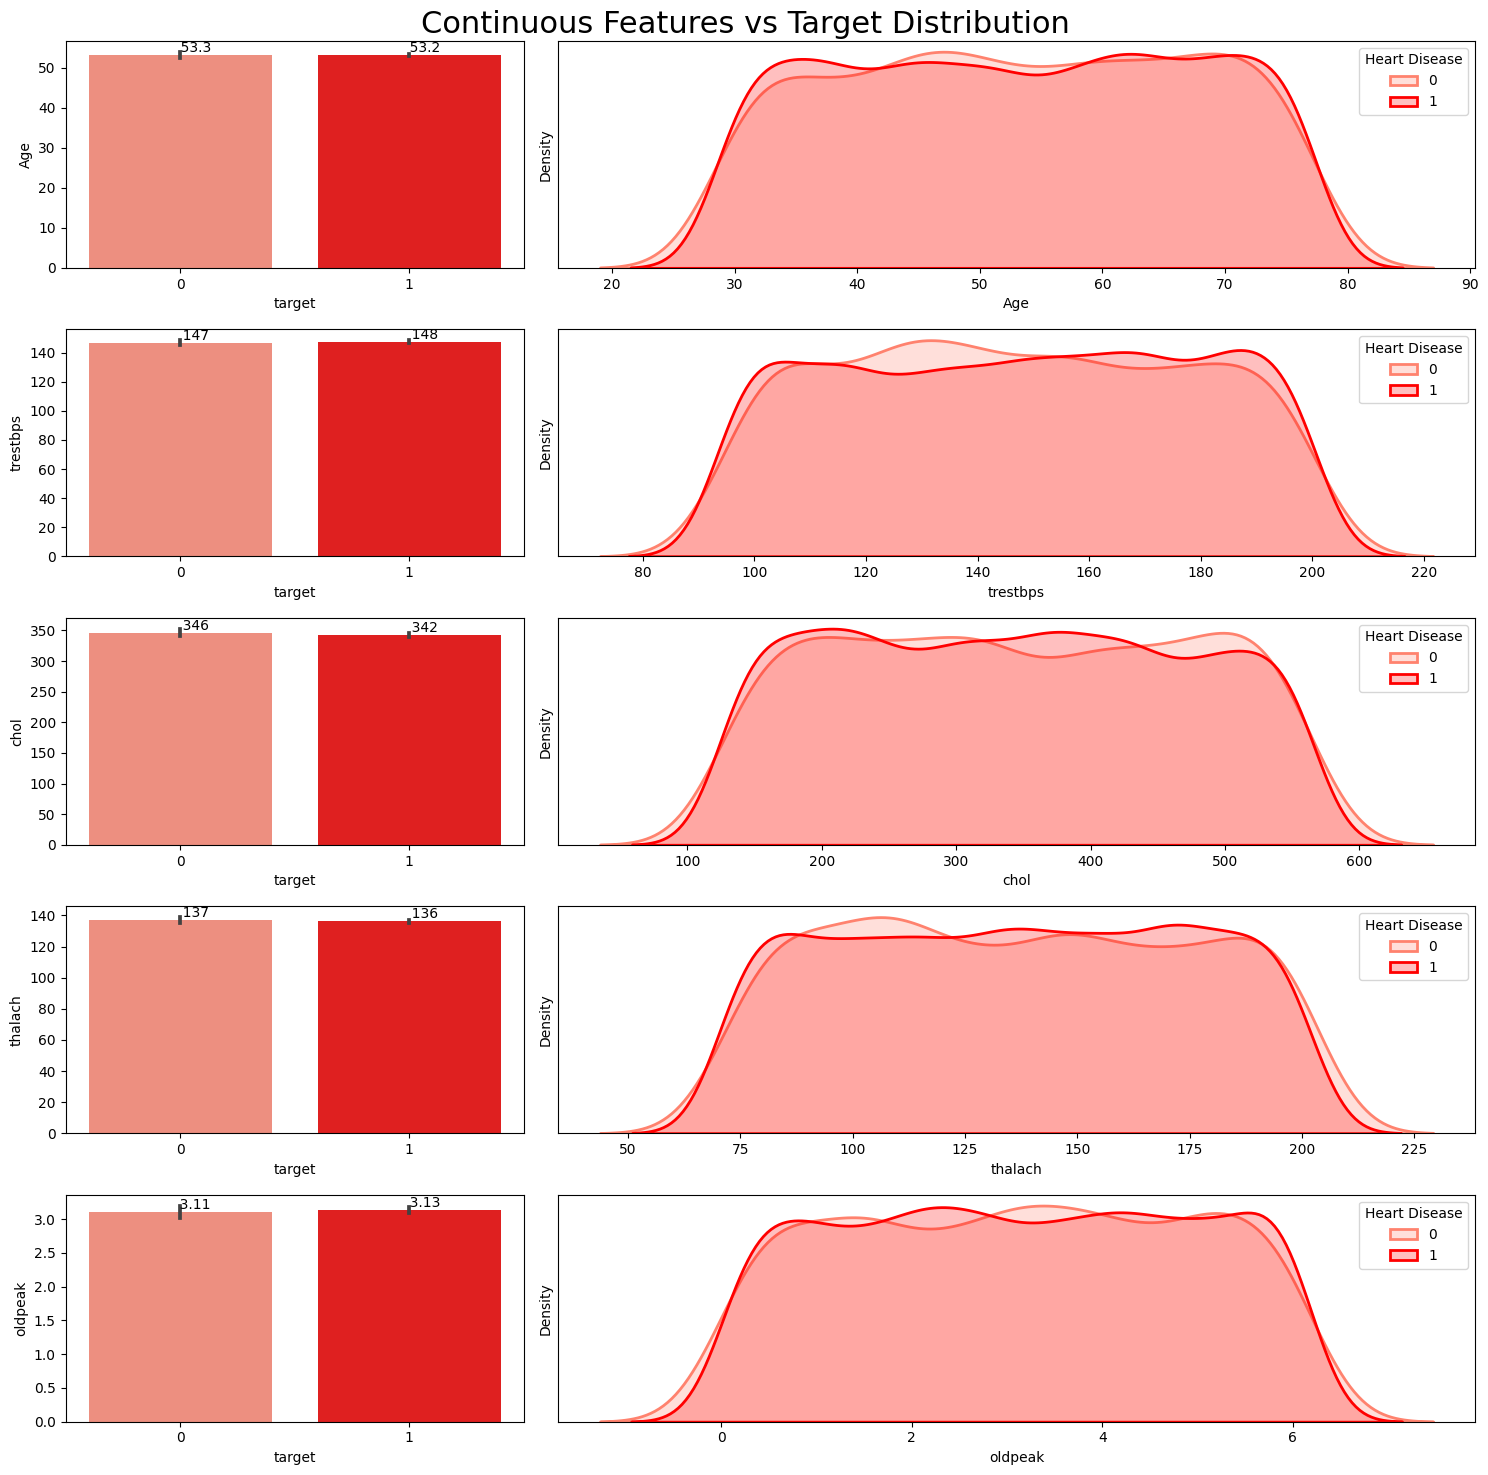

In [15]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=data_train, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=data_train[data_train["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=data_train[data_train["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='       %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

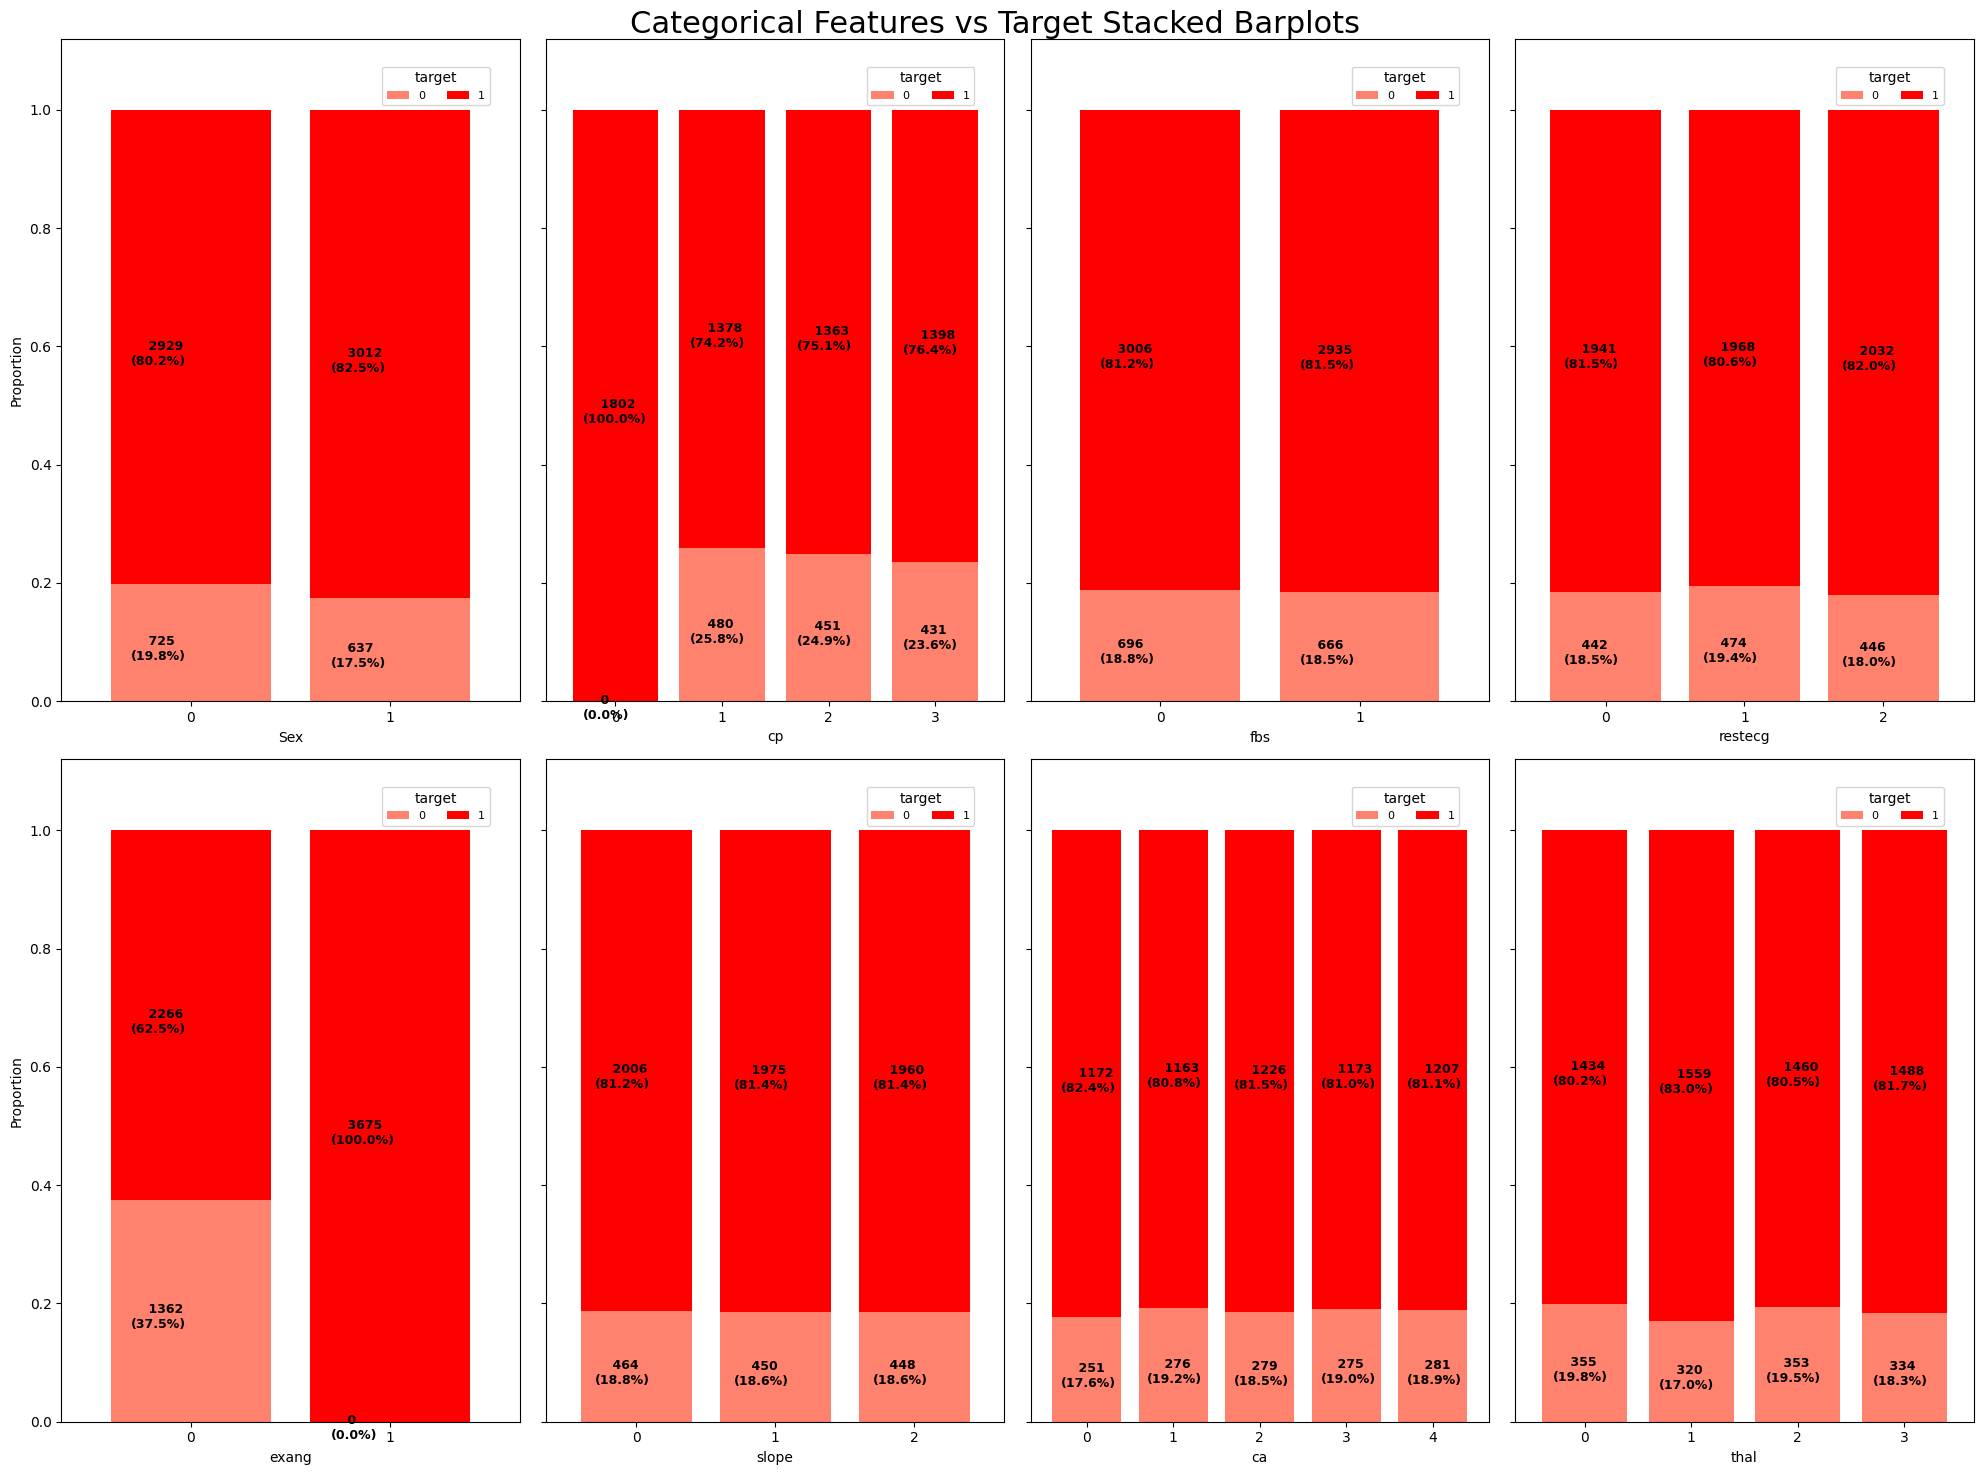

In [16]:
categorical_features = [feature for feature in categorical_features if feature != 'target']


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,15))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=data_train[col], columns=data_train['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=data_train[col], columns=data_train['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

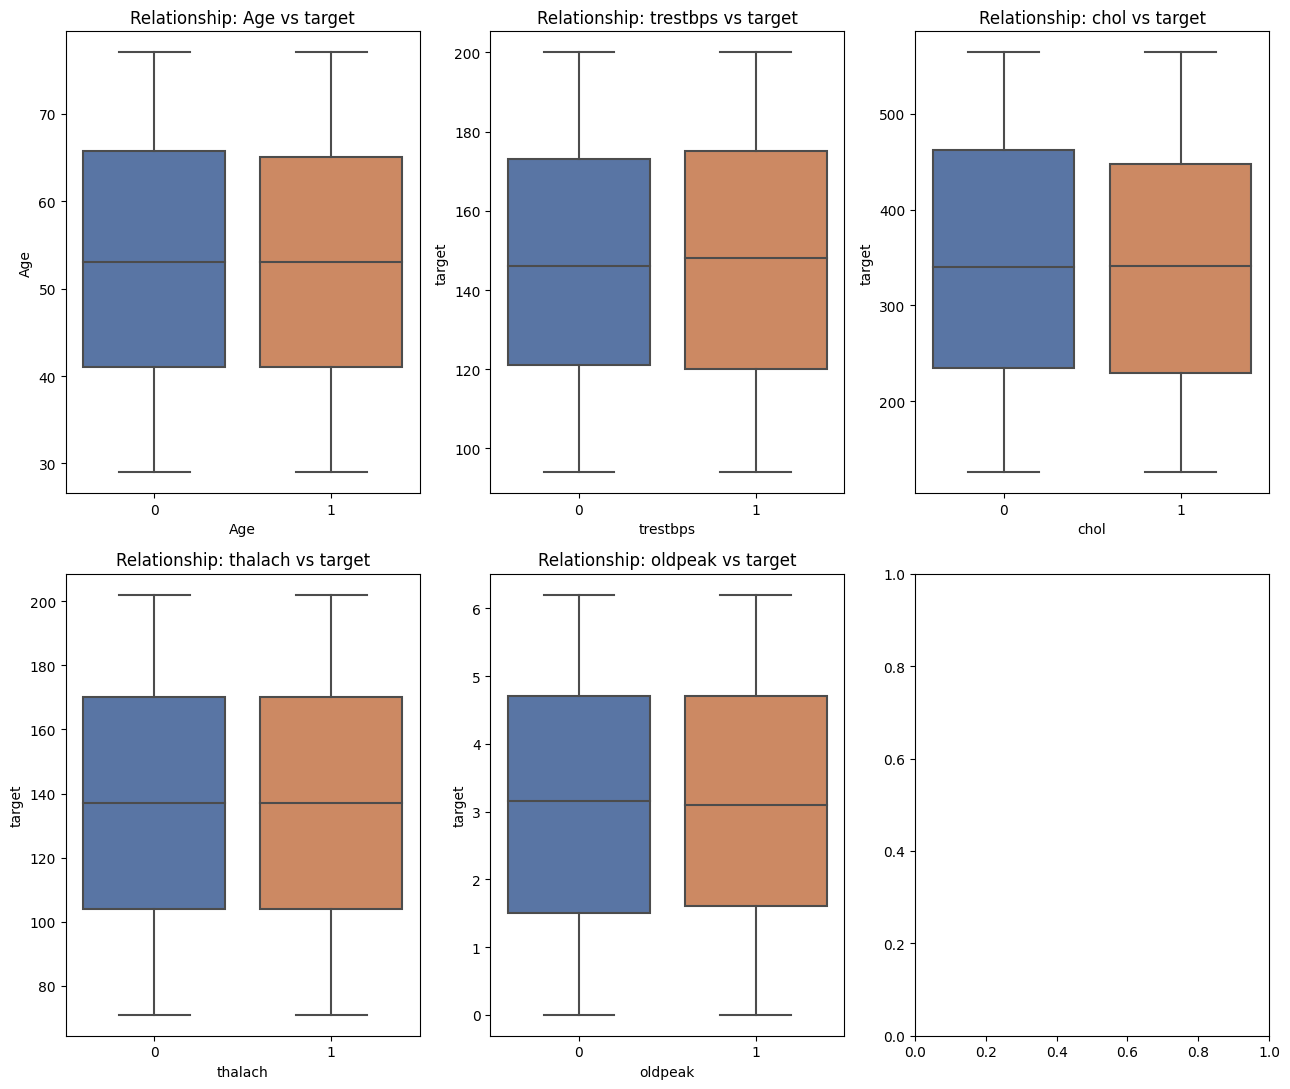

In [17]:
deep='deep'

fig, axes = plt.subplots(2, 3, figsize=(13, 11))

sns.boxplot(x = 'target', y = 'Age', data = data_train, palette=deep, ax=axes[0, 0])
axes[0, 0].set_xlabel('Age')
axes[0, 2].set_ylabel('target')
axes[0, 0].set_title('Relationship: Age vs target')

sns.boxplot(x = 'target', y='trestbps', data = data_train, palette=deep, ax=axes[0, 1])
axes[0, 1].set_xlabel('trestbps')
axes[0, 1].set_ylabel('target')
axes[0, 1].set_title('Relationship: trestbps vs target')

sns.boxplot(x = 'target', y='chol', data=data_train ,palette=deep, ax=axes[0, 2])
axes[0, 2].set_xlabel('chol')
axes[0, 2].set_ylabel('target')
axes[0, 2].set_title('Relationship: chol vs target')

sns.boxplot(x = 'target',y='thalach', data=data_train, palette=deep, ax=axes[1, 0])
axes[1, 0].set_xlabel('thalach')
axes[1, 0].set_ylabel('target')
axes[1, 0].set_title('Relationship: thalach vs target')

sns.boxplot(x = 'target', y='oldpeak', data= data_train, palette=deep, ax=axes[1, 1])
axes[1, 1].set_xlabel('oldpeak')
axes[1, 1].set_ylabel('target')
axes[1, 1].set_title('Relationship: oldpeak vs target')



plt.tight_layout()

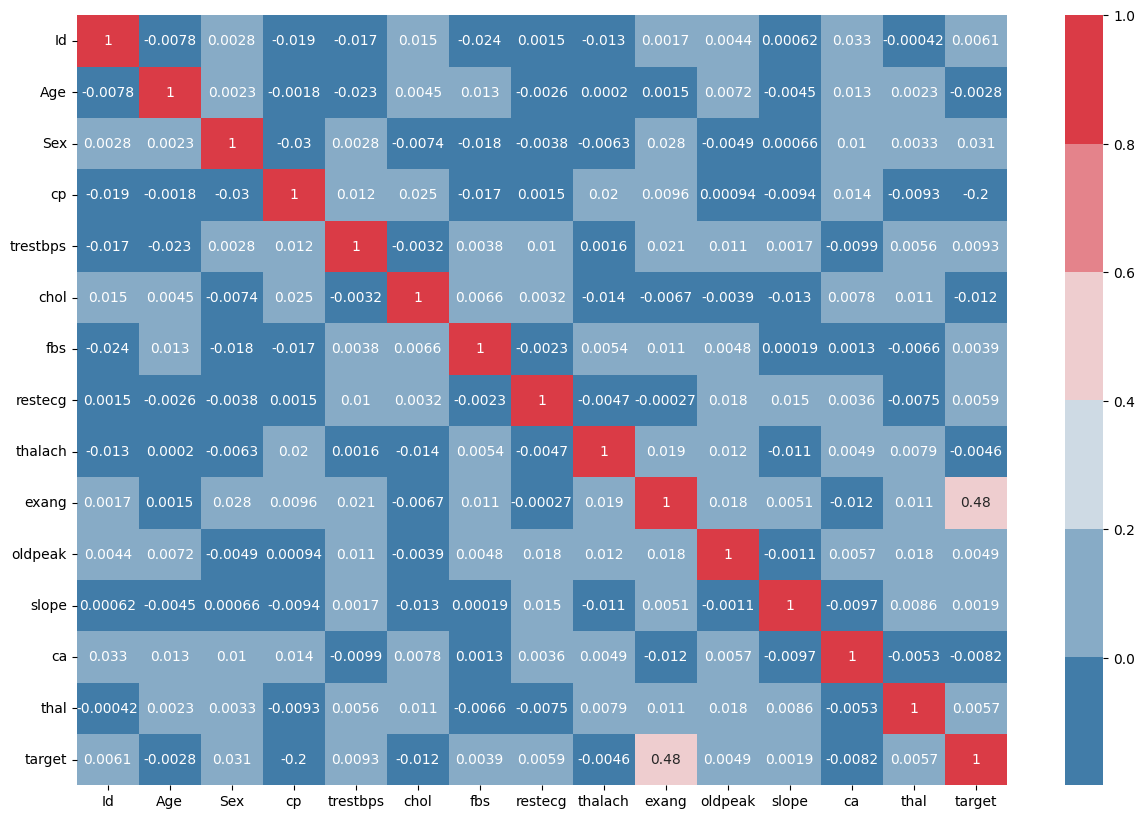

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(data = data_train.corr(),annot=True, cbar=True,cmap=sns.diverging_palette(240,10))
plt.show()

**EDA Insights**

* The numerical features are approximately uniformly distributed
* The unique category count of each feature are nearly equal except the target feature which has    81.4% of heart disease cases and 18.6% of non heart disease cases
* All Patients with typical Angina chest pain type have heart disease
* All Patients that experiences chest pain during exercise have heart disease
* There are no relationships or correlation between the numerical features

# Using Mutual Information to Identify Promising Features

In [19]:
from sklearn.feature_selection import mutual_info_classif

#create a copy of the train_data
mi_data = data_train.copy()
y_tg = mi_data['target']  
X_ft = mi_data.drop(columns='target') 


# Calculate mutual information
mi_scores = mutual_info_classif(X_ft, y_tg, random_state=2)
mi_scores = pd.Series(mi_scores, index=X_ft.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

exang       0.150480
cp          0.051443
ca          0.008439
thal        0.007188
Age         0.002943
restecg     0.001312
trestbps    0.000859
Id          0.000000
Sex         0.000000
chol        0.000000
fbs         0.000000
thalach     0.000000
oldpeak     0.000000
slope       0.000000
dtype: float64


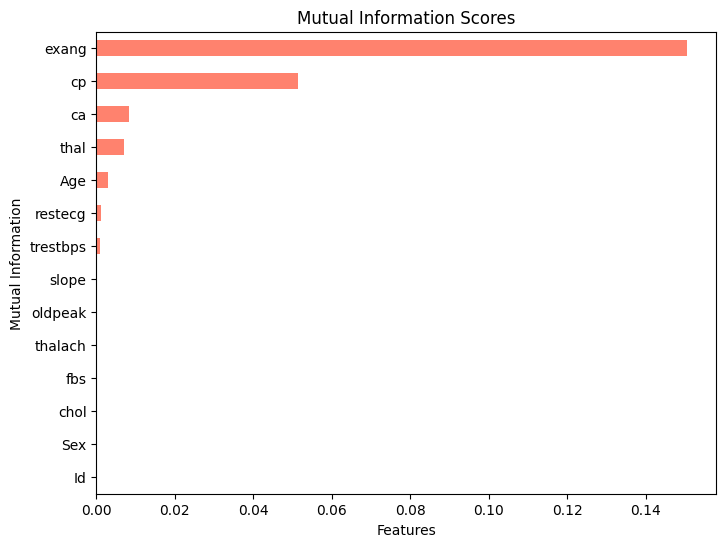

In [20]:
# Plot the mutual information scores
plt.figure(figsize=(8, 6))
mi_scores.sort_values(ascending=True).plot(kind='barh')
plt.title('Mutual Information Scores')
plt.ylabel('Mutual Information')
plt.xlabel('Features')
plt.show()

Mutual Information (MI) helps measure the dependency between two variables. It tells you how much information the input feature provides about the target variable. 
From the mutual information scores above, exang,cp,ca,thal,Age,restecg,and trestbps have sufficient info about the target. Hence these features are useful for predicting the target

# Using Permutation Information to Identify promising features

In [21]:
import eli5
from eli5.sklearn import PermutationImportance

X1, X2, y1, y2 = train_test_split(X_ft, y_tg, test_size=0.2, random_state=4)
perm_model = LogisticRegression(random_state=4)
perm_model.fit(X1,y1)
perm_imp = PermutationImportance(perm_model,random_state=4,n_iter=10).fit(X2,y2)
eli5.show_weights(perm_imp, feature_names = X2.columns.tolist())

In [22]:
feature_importance = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': perm_imp.feature_importances_,
    'Std Dev': perm_imp.feature_importances_std_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance

Feature    Importance   Std Dev
9      exang  1.266256e-02  0.003533
3         cp  1.006160e-02  0.001913
4   trestbps  8.555784e-03  0.002059
5       chol  5.133470e-03  0.002013
10   oldpeak  3.080082e-03  0.001942
1        Age  2.669405e-03  0.003158
12        ca  1.574264e-03  0.000616
2        Sex  8.898015e-04  0.000868
11     slope  8.213552e-04  0.000411
13      thal  8.213552e-04  0.000737
6        fbs  0.000000e+00  0.000000
8    thalach  0.000000e+00  0.000000
0         Id -2.220446e-17  0.001677
7    restecg -3.422313e-04  0.000631

In [23]:
perm_model2 = CatBoostClassifier(random_state=4,verbose=False)
perm_model2.fit(X1,y1)
perm_imp2 = PermutationImportance(perm_model2,random_state=4,n_iter=10).fit(X2,y2)
eli5.show_weights(perm_imp2, feature_names = X2.columns.tolist())

In [24]:
perm_model3 = RandomForestClassifier(random_state=3)
perm_model3.fit(X1,y1)
perm_imp3 = PermutationImportance(perm_model3,random_state=4,n_iter=10).fit(X2,y2)
eli5.show_weights(perm_imp3, feature_names = X2.columns.tolist())

The results gotten from the permutation importance are similar to those of mutual information but with some minor difference. 
In general 
* exang
* cp
* ca
* trestbps
* chol
* oldpeak
* thal
* age
 
are very useful features. Although exang and cp are considered the most important

# Lets see how these features affect predictions using Partial dependence display plots(PDP)

In [25]:
from sklearn.inspection import PartialDependenceDisplay

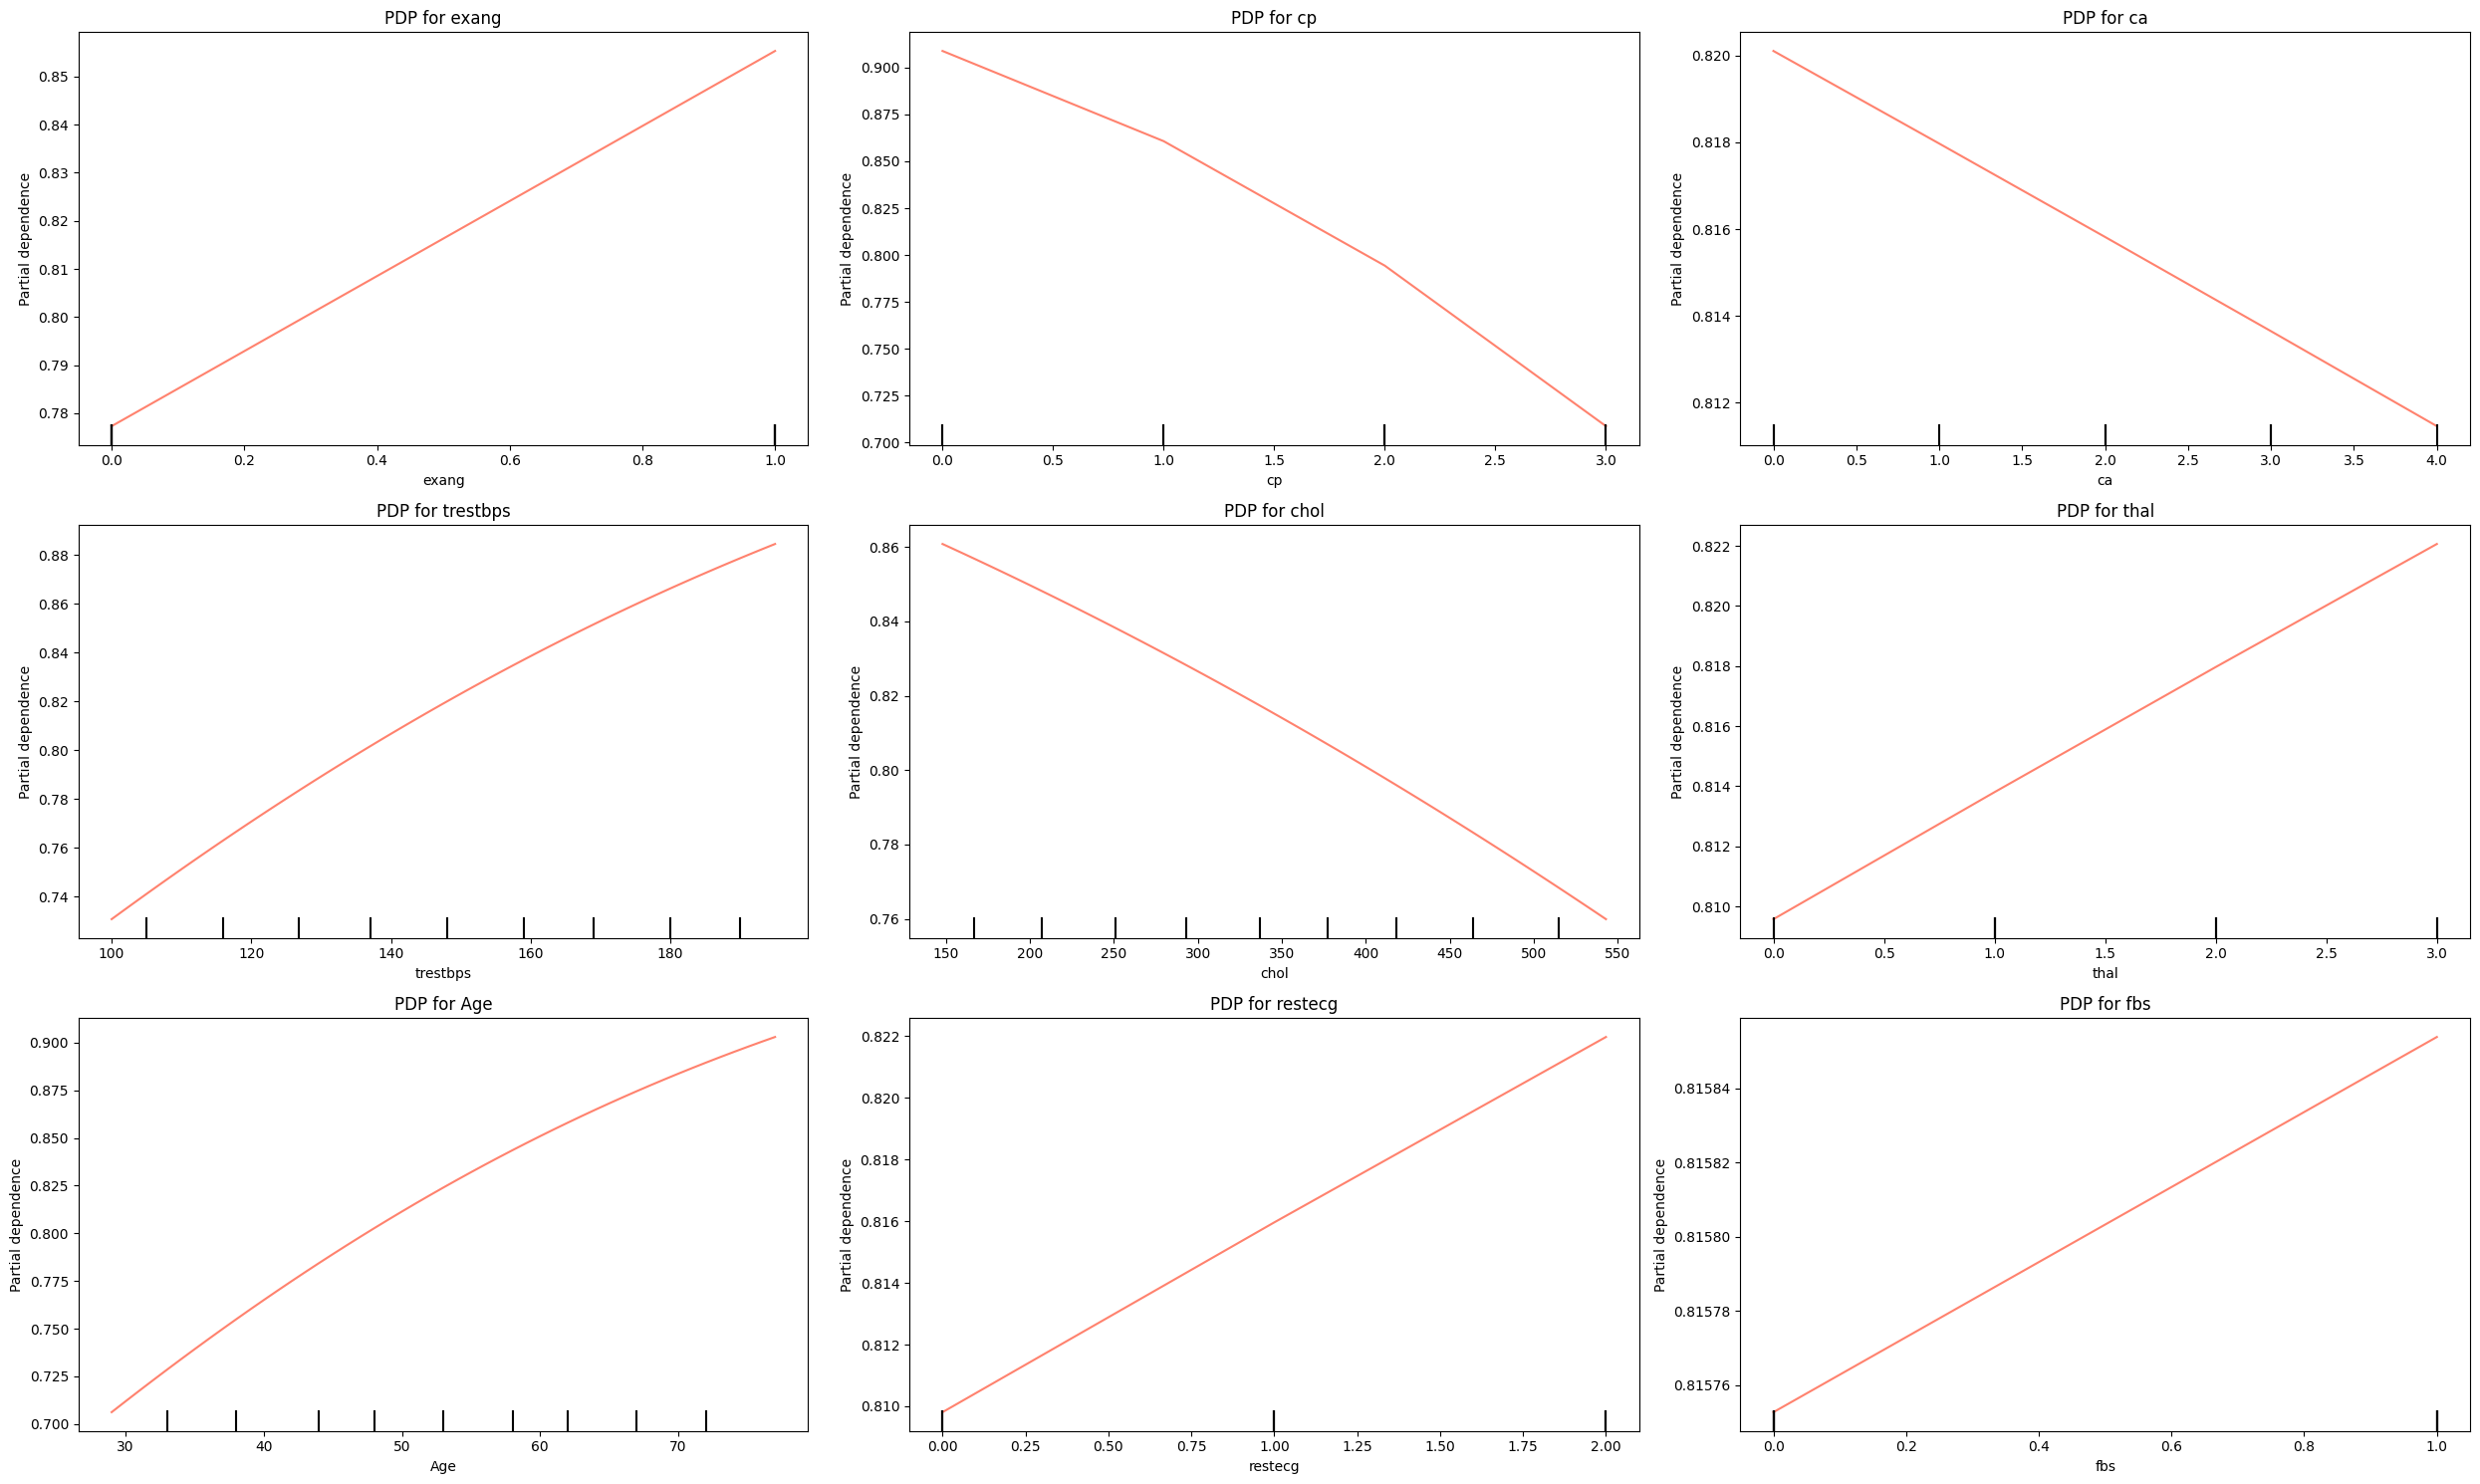

In [26]:
# Define the features to plot
features_to_plot = ['exang', 'cp', 'ca', 'trestbps', 'chol', 'thal', 'Age', 'restecg','fbs']

# 2 by 4 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(3, 3, figsize=(25, 15))

# Loop through the features and plot the PDP for each feature
for i, feature in enumerate(features_to_plot):
    row, col = divmod(i, 3)  # Calculate row and column index for subplot
    PartialDependenceDisplay.from_estimator(perm_model, X2, [feature], ax=axes[row, col])
    axes[row, col].set_title(f"PDP for {features_to_plot[i]}")  # Set title for each subplot

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

Partial dependence plots shows how features affect the predictions. For the logistic regression model exang,cp,ca,thal,trestbps,restecg,fbs,Age,and chol exhibit a linear relationship. The x-axis represents the feature and the y-axis represents the average model prediction for the target variable. Taking exang for example; The feature exang contains two unique category 0 and 1. The dependence plots shows us that when the feature exang value is zero, the model predicts a lower chance of heart disease (i.e the probability of an individual with exang value 0 having a heart disease is low). When the exang feature value is one, the model predicts a higher chance of a heart disease.


**Lets try RandomForest**

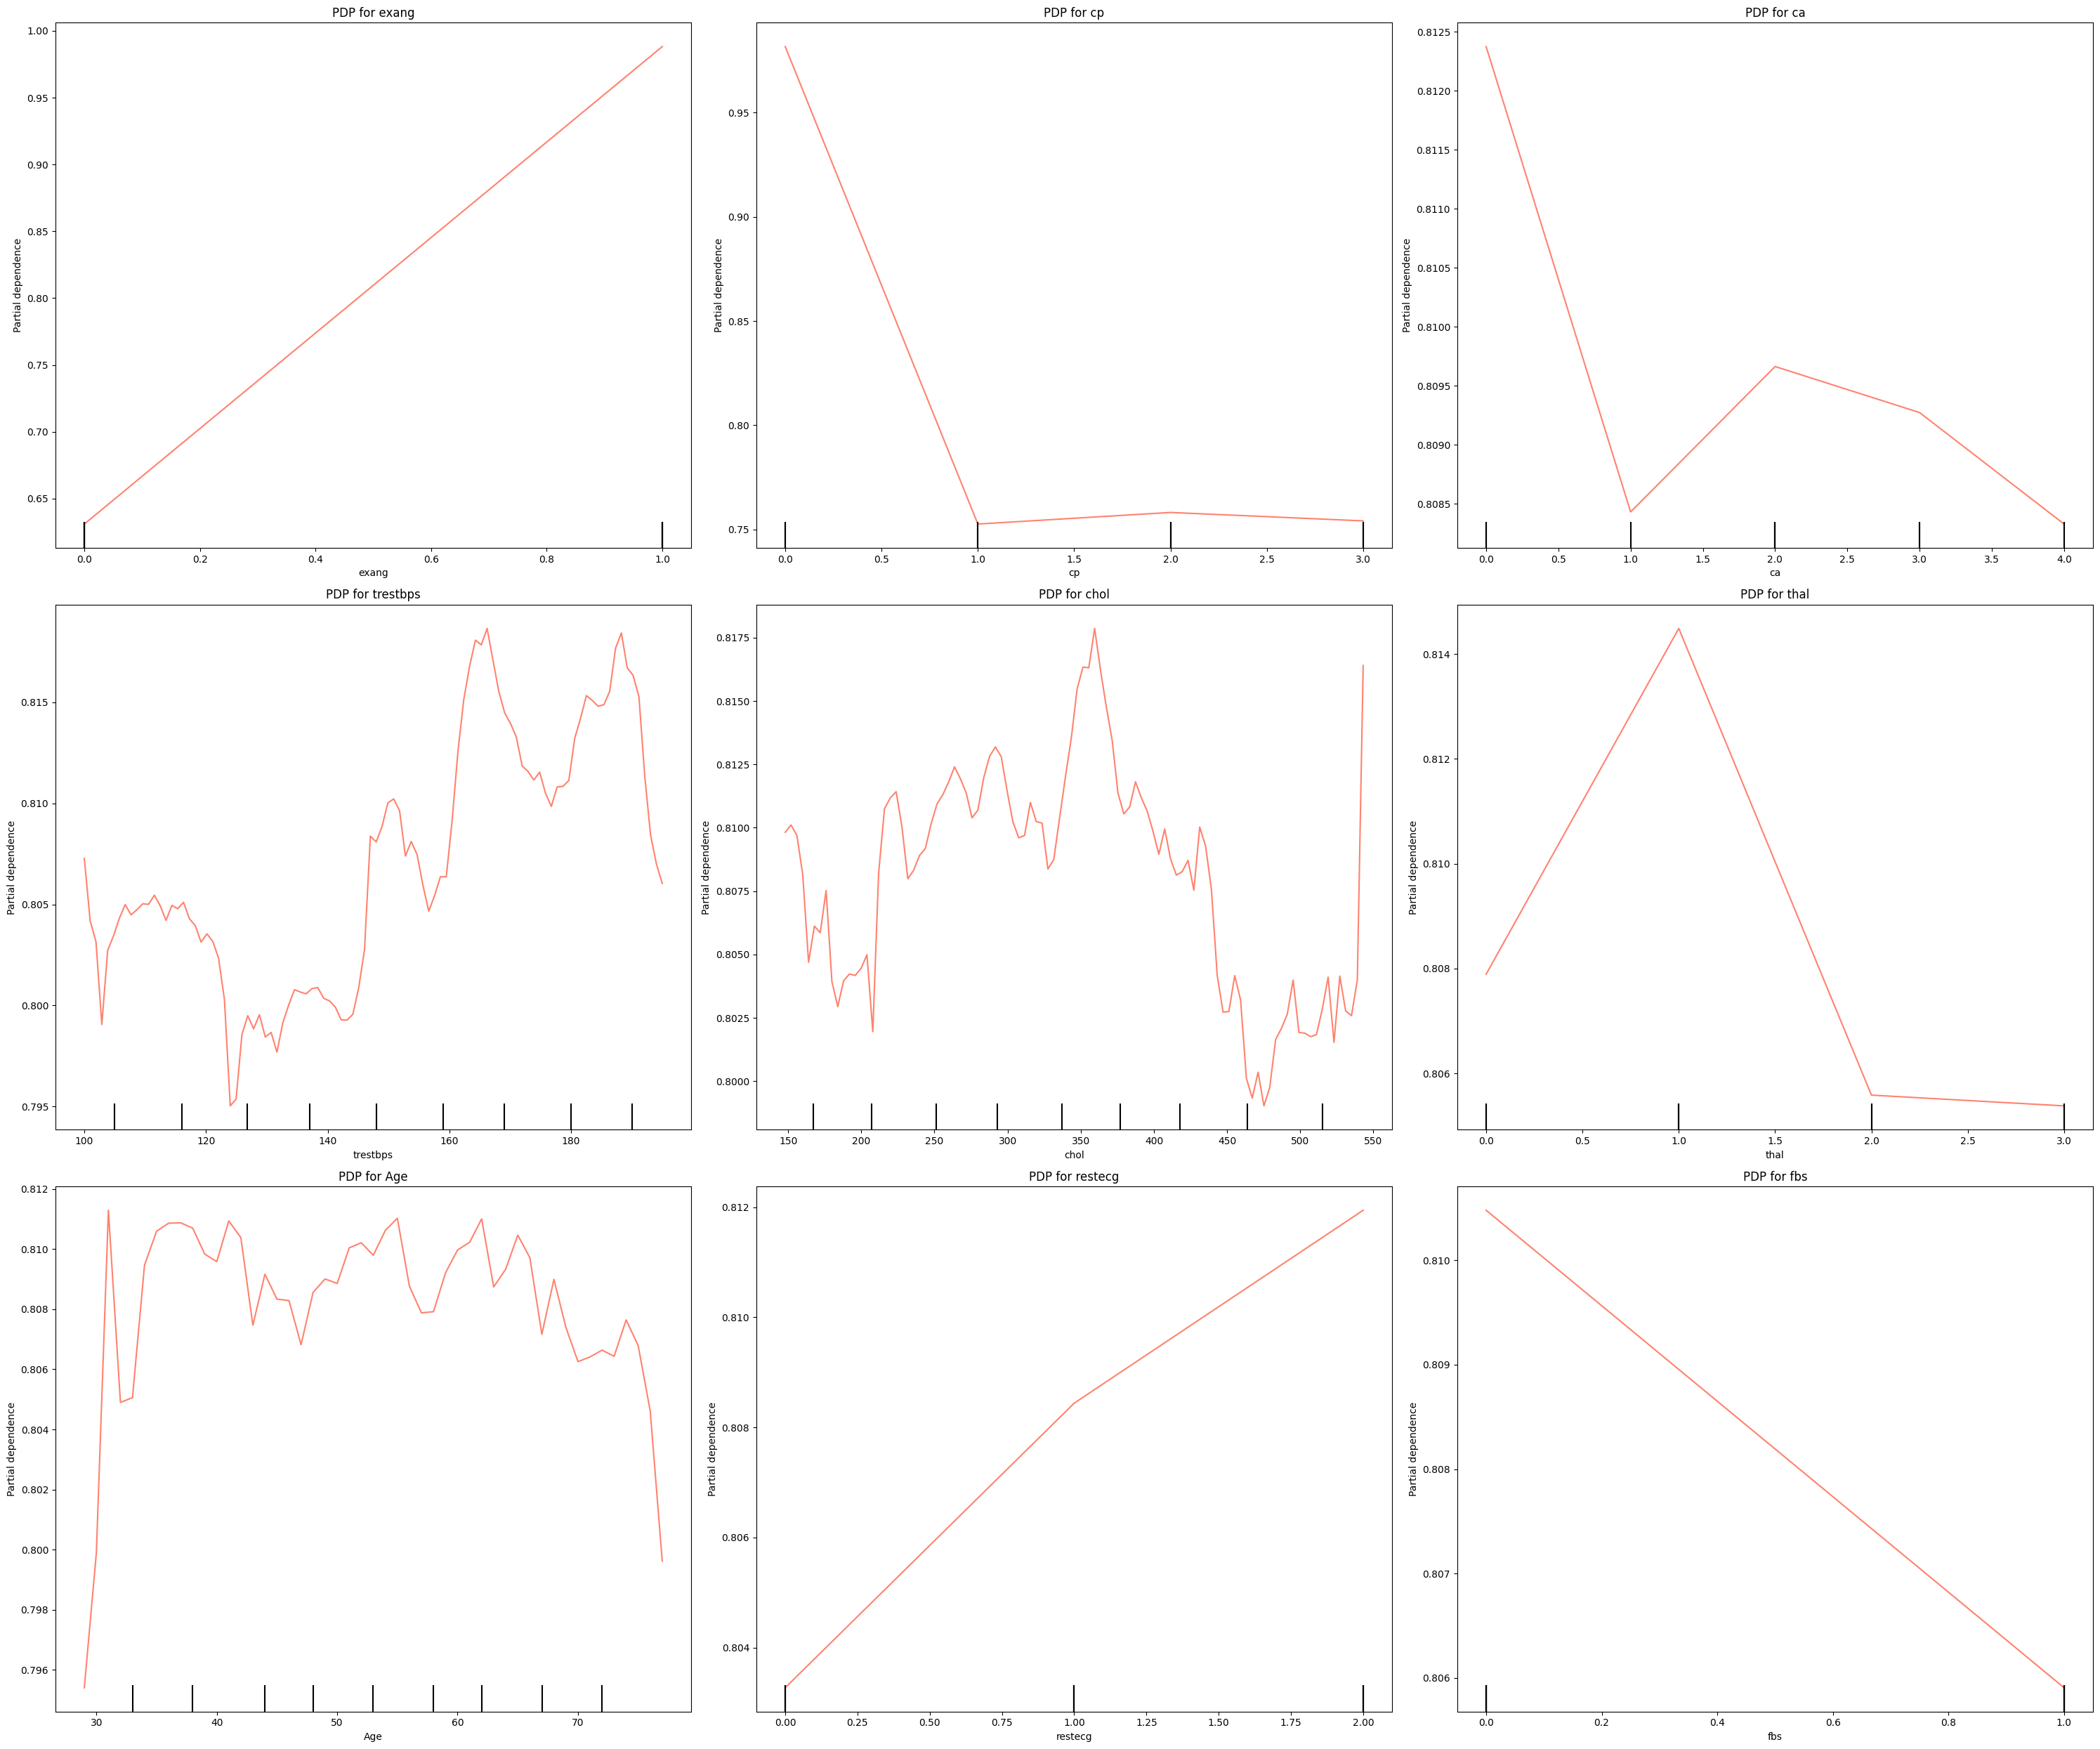

In [27]:
# Define the features to plot
features_plot = ['exang', 'cp', 'ca', 'trestbps', 'chol', 'thal', 'Age', 'restecg','fbs']

# 2 by 4 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(3, 3, figsize=(30, 25))

# Loop through the features and plot the PDP for each feature
for i, feature in enumerate(features_plot):
    row, col = divmod(i, 3)  # Calculate row and column index for subplot
    PartialDependenceDisplay.from_estimator(perm_model3, X2, [feature], ax=axes[row, col])
    axes[row, col].set_title(f"PDP for {features_plot[i]}")  # Set title for each subplot

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

trestbps, chol, and age show a more complex relationship compared to what was shown by the logistic regression model.The random forest model tells us that pateients with a 0 value for the cp feature are more likey to have a heart disease compared to when the cp values are 1,2, and 3.

for the ca feature, the probability of the individual having a heart disease decreases as the cp value moves from 0 to 1

The probability of an individual having a heart disease is high for thal value of 1 compared to other values

**Lets try catboost**

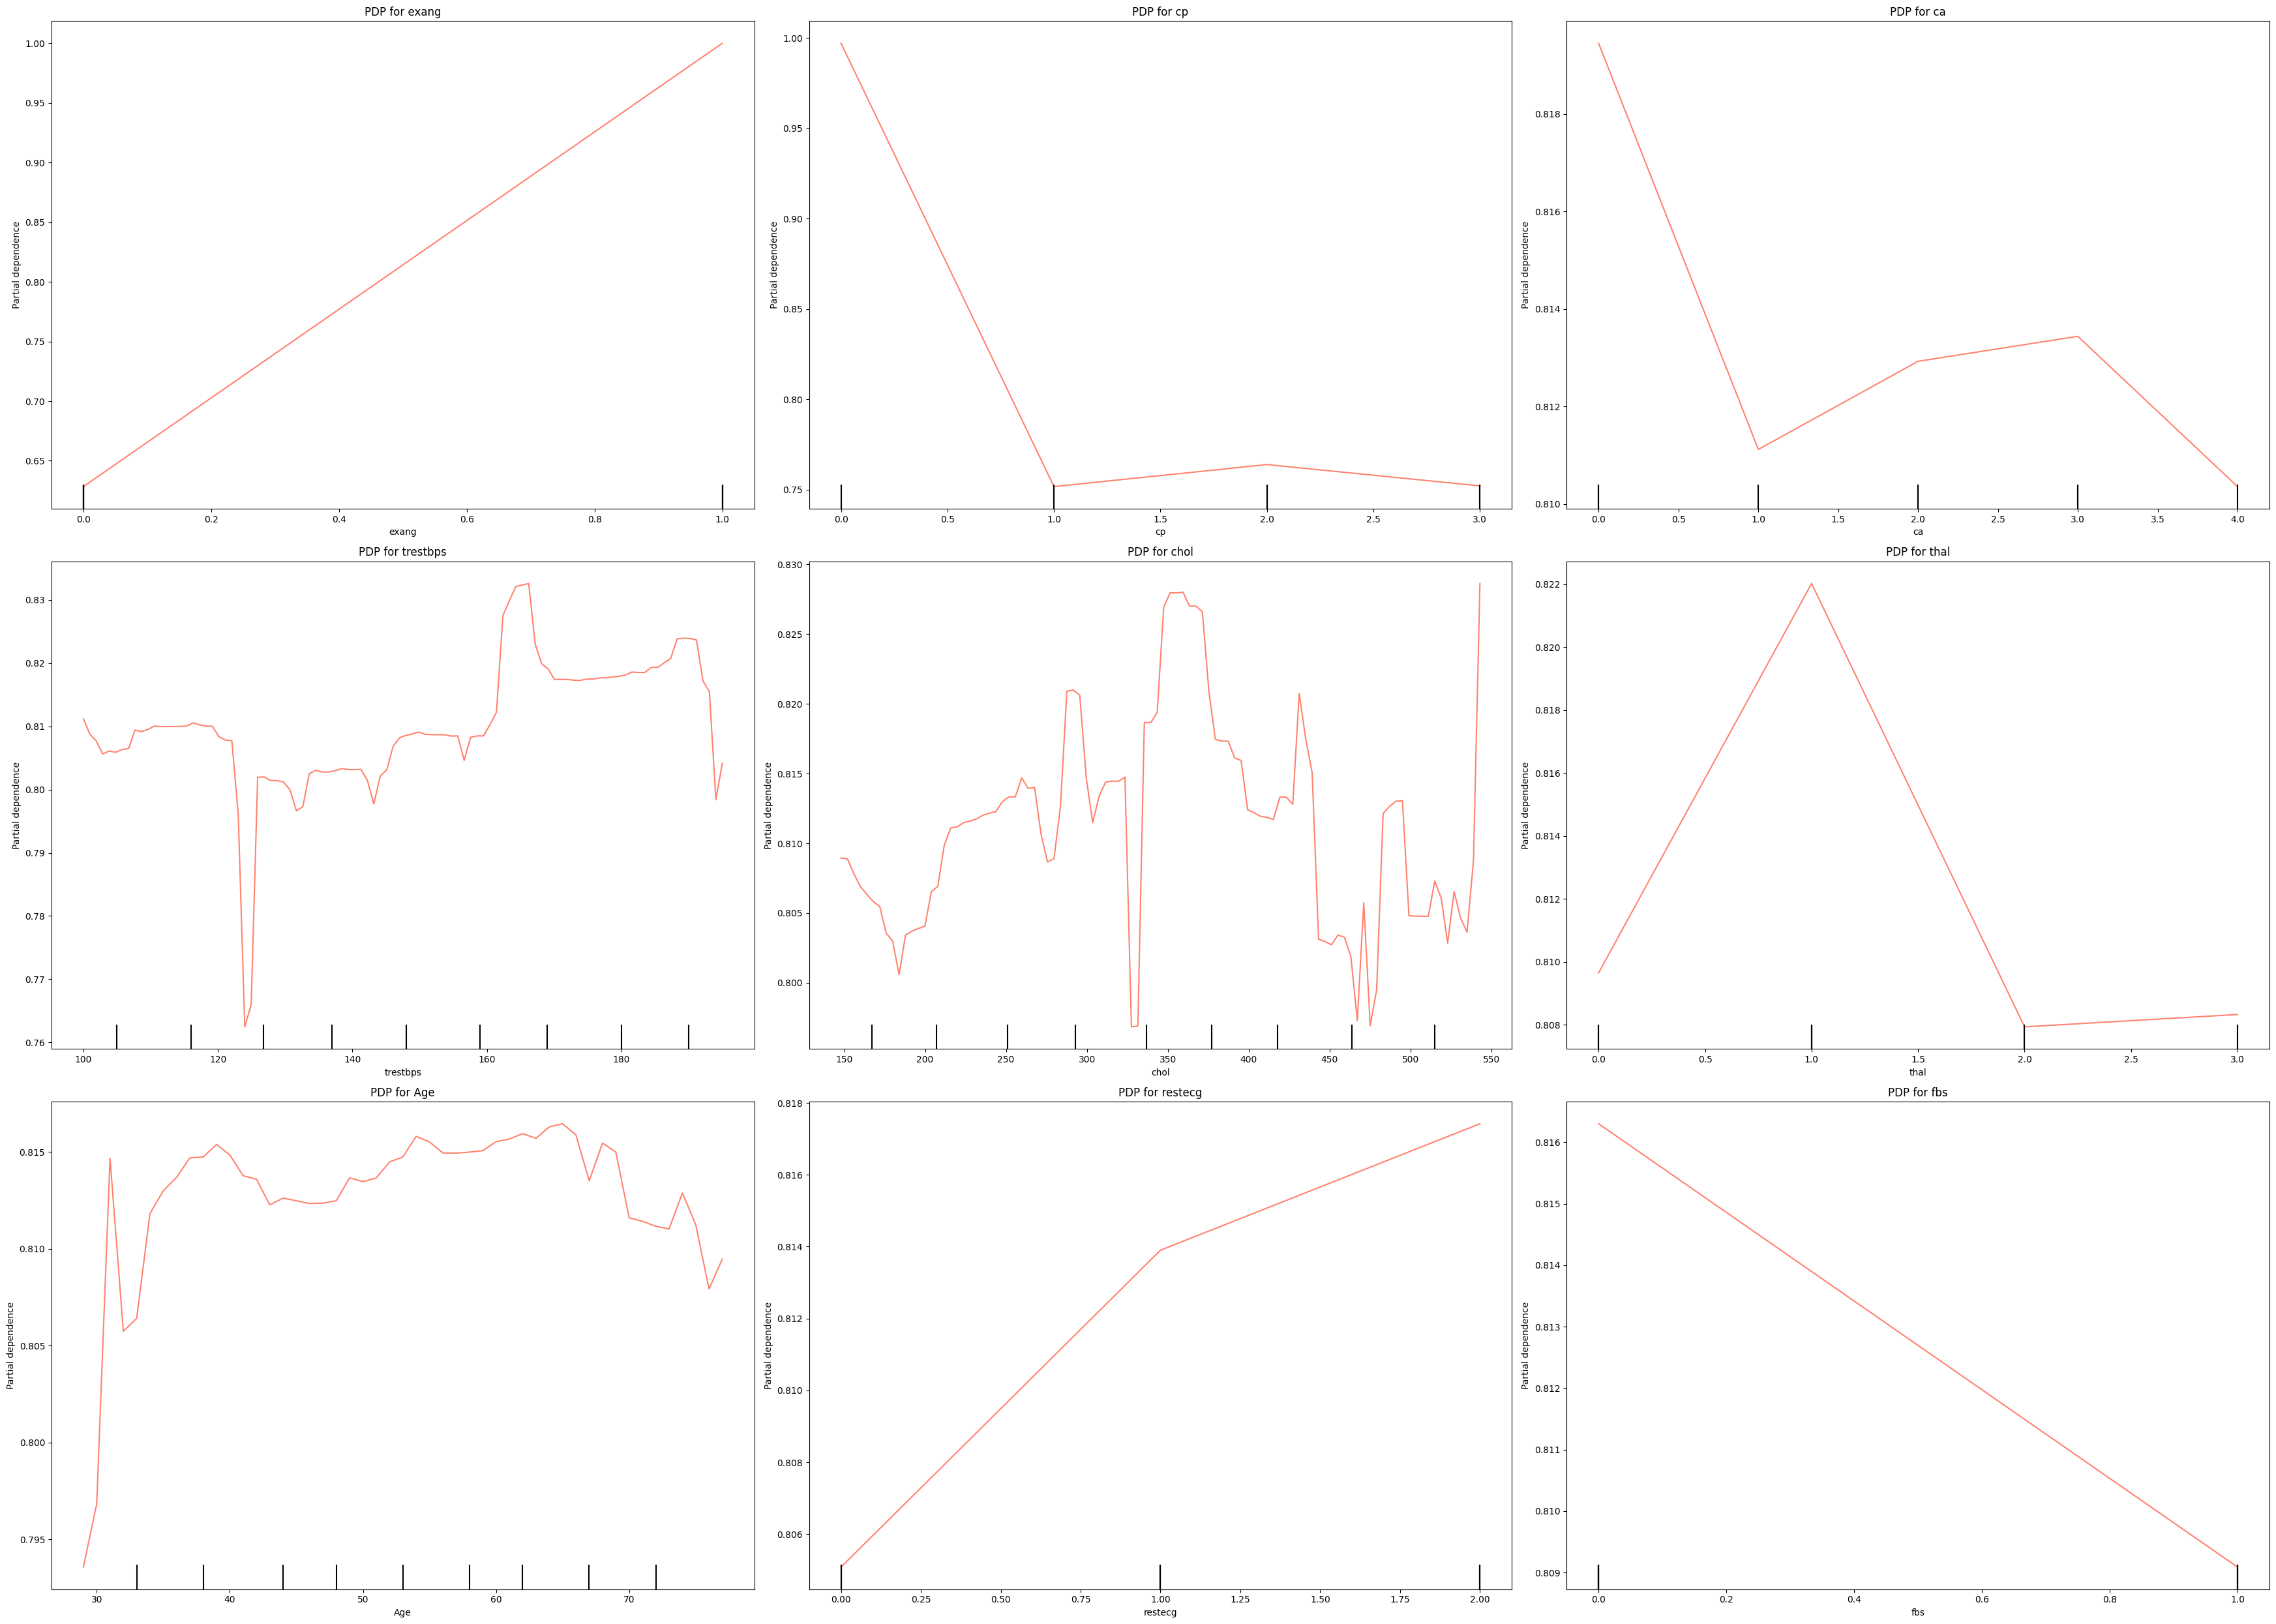

In [28]:
# Define the features to plot
features = ['exang', 'cp', 'ca', 'trestbps', 'chol', 'thal', 'Age', 'restecg','fbs']

# 2 by 4 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(3, 3, figsize=(35, 25))

# Loop through the features and plot the PDP for each feature
for i, feature in enumerate(features):
    row, col = divmod(i, 3)  # Calculate row and column index for subplot
    PartialDependenceDisplay.from_estimator(perm_model2, X2, [feature], ax=axes[row, col])
    axes[row, col].set_title(f"PDP for {features[i]}")  # Set title for each subplot

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Two way PDP plots

In [29]:
feature_pair1 = [("exang", "cp")]
feature_pair2 = [("exang", "ca")]
feature_pair3 = [("exang", "trestbps")]
feature_pair4 = [("exang", "chol")]
feature_pair5 = [("exang", "thal")]
feature_pair6 = [("exang", "Age")]
feature_pair7 = [("exang", "restecg")]
feature_pair8 = [("exang", "fbs")]
feature_pair9 = [("cp", "ca")]
feature_pair10 = [("cp", "trestbps")]
feature_pair11 = [("cp", "chol")]
feature_pair12 = [("cp", "thal")]
feature_pair13 = [("cp", "Age")]
feature_pair14 = [("cp", "restecg")]
feature_pair15 = [("cp", "fbs")]
feature_pair16 = [("ca", "trestbps")]
feature_pair17 = [("ca", "chol")]
feature_pair18 = [("ca", "thal")]
feature_pair19 = [("ca", "Age")]
feature_pair20 = [("ca", "restecg")]
feature_pair21 = [("ca", "fbs")]
feature_pair22 = [("trestbps", "chol")]
feature_pair23 = [("trestbps", "thal")]
feature_pair24 = [("trestbps", "Age")]
feature_pair25 = [("chol", "thal")]
feature_pair26 = [("chol", "Age")]
feature_pair27 = [("chol", "restecg")]
feature_pair28 = [("chol", "fbs")]
feature_pair29 = [("thal", "Age")]
feature_pair30 = [("thal", "restecg")]
feature_pair31 = [("thal", "fbs")]
feature_pair32 = [("Age", "restecg")]
feature_pair33 = [("Age", "fbs")]
feature_pair34 = [("restecg", "fbs")]


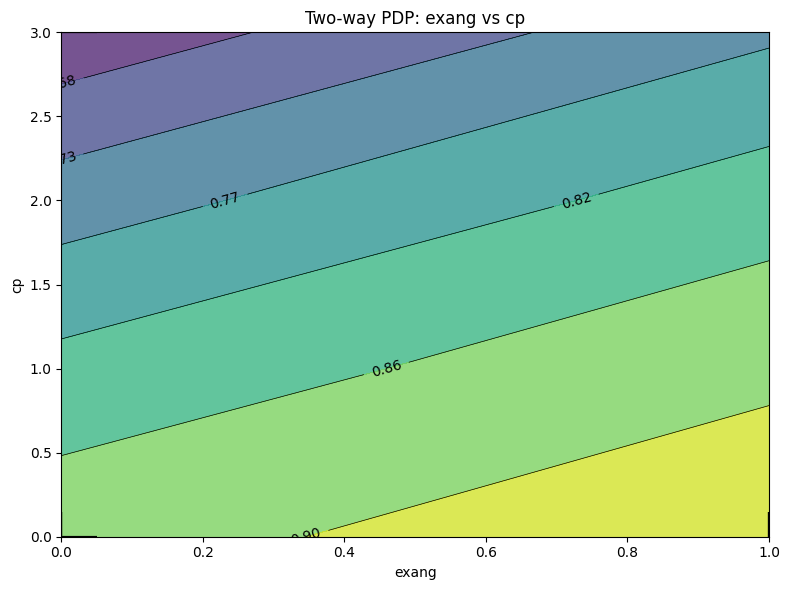

In [30]:
#Logistic Regression

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model,X2,feature_pair1,ax=ax)

ax.set_title("Two-way PDP: exang vs cp")
plt.tight_layout() 
plt.show()

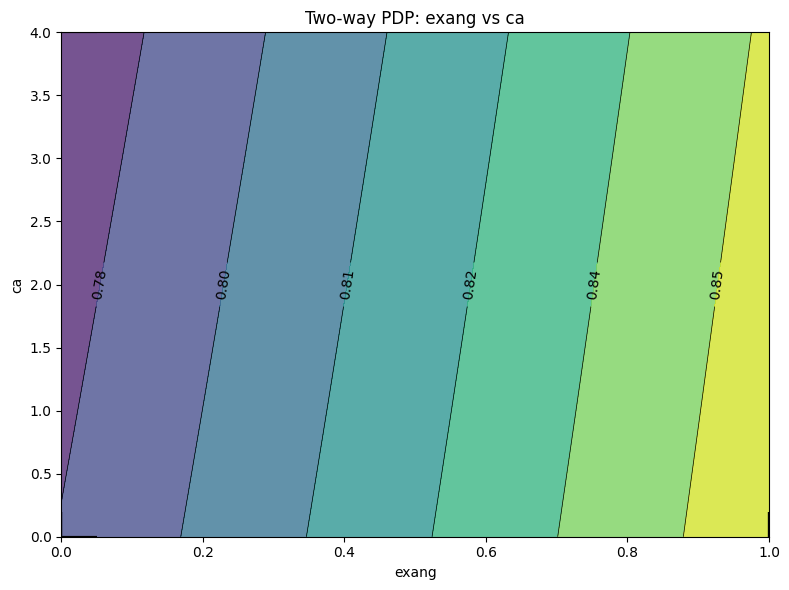

In [31]:
#Logistic Regression

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model,X2,feature_pair2,ax=ax)

ax.set_title("Two-way PDP: exang vs ca")
plt.tight_layout() 
plt.show()

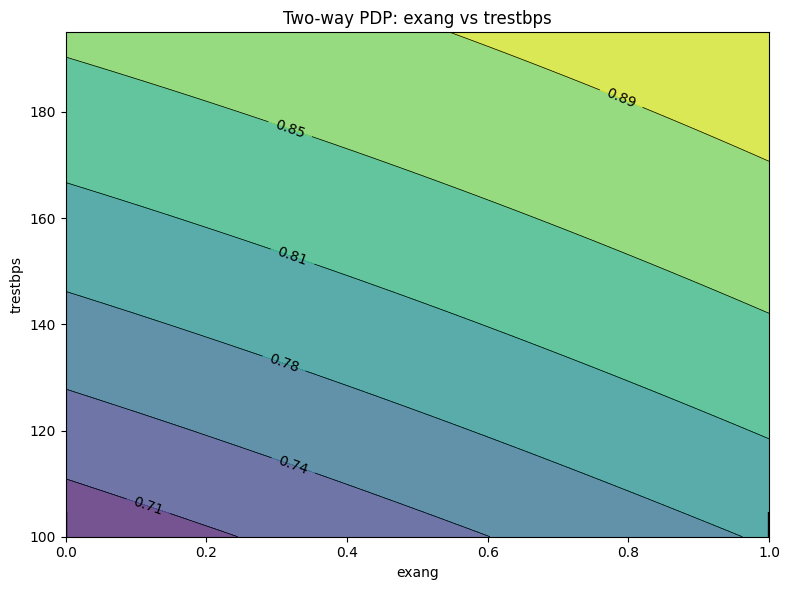

In [32]:
#Logistic Regression

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model,X2,feature_pair3,ax=ax)

ax.set_title("Two-way PDP: exang vs trestbps")
plt.tight_layout() 
plt.show()

The dependency plots showing the relationship between features as given by the logistic regression is most likely too simple as it can only detect linear relationships. So let's use a more complex model to investigate.

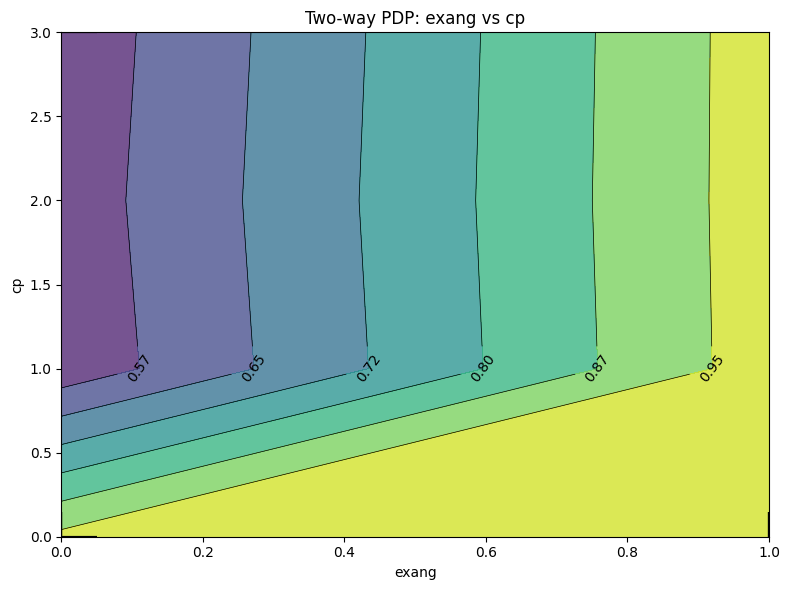

In [33]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair1,ax=ax)

ax.set_title("Two-way PDP: exang vs cp")
plt.tight_layout() 
plt.show()

The PDP above tells us that the probability of a patient having a heart disease is high when the exang value is 1 (close to 1) and cp value is closer to zero. This gives us an insight that these two features are very important in predicting if a patient has heart disease or not.

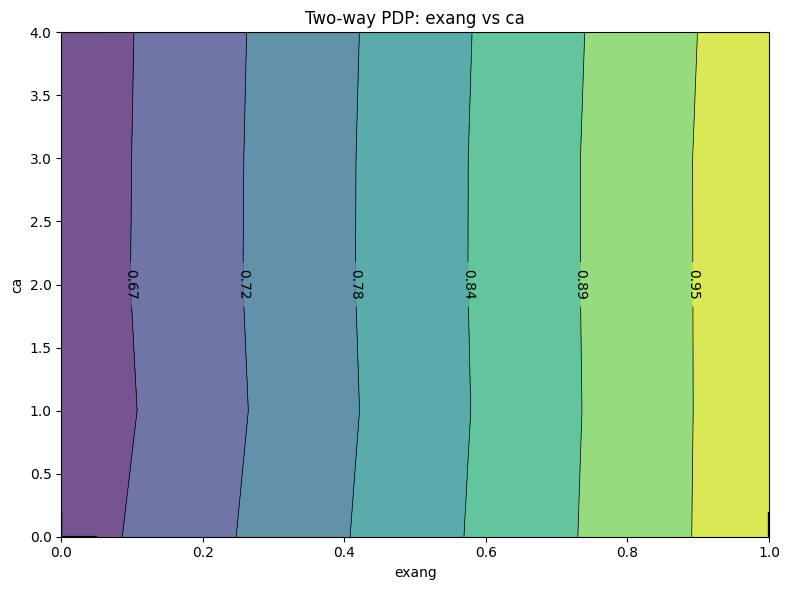

In [34]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair2,ax=ax)

ax.set_title("Two-way PDP: exang vs ca")
plt.tight_layout() 
plt.show()

ca has little or no effect in predicting if a patient has heart disease or not compared to exang.

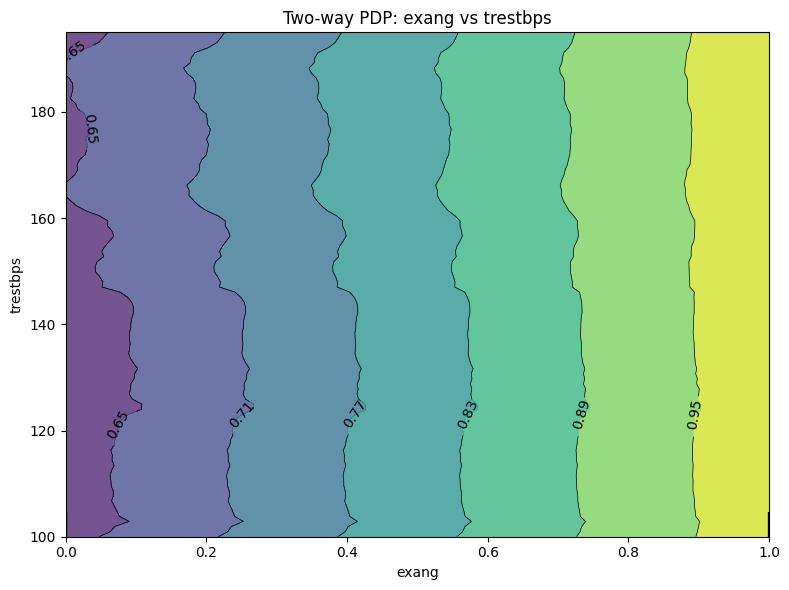

In [35]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair3,ax=ax)

ax.set_title("Two-way PDP: exang vs trestbps")
plt.tight_layout() 
plt.show()

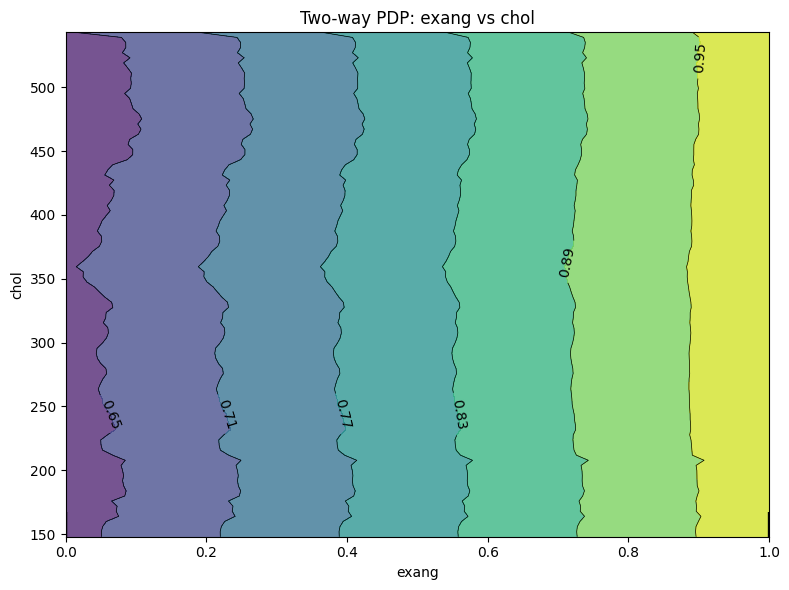

In [36]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair4,ax=ax)

ax.set_title("Two-way PDP: exang vs chol")
plt.tight_layout() 
plt.show()

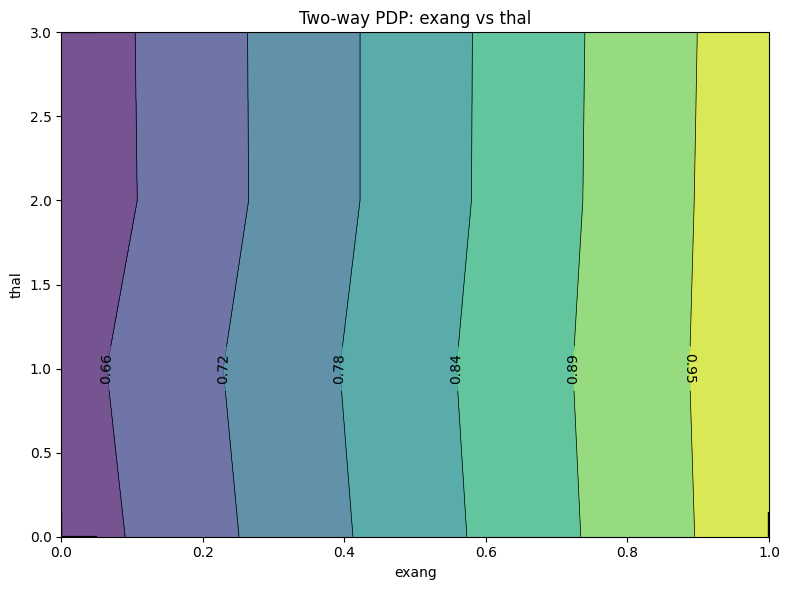

In [37]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair5,ax=ax)

ax.set_title("Two-way PDP: exang vs thal")
plt.tight_layout() 
plt.show()

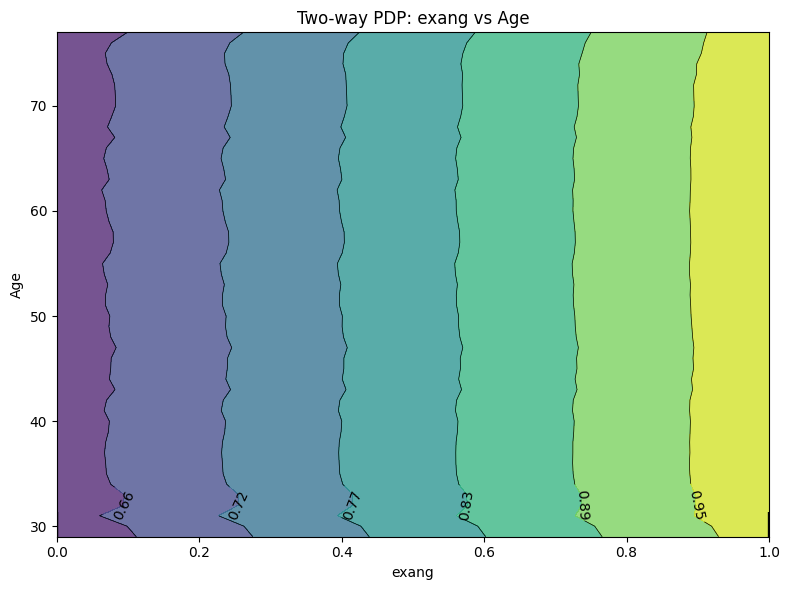

In [38]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair6,ax=ax)

ax.set_title("Two-way PDP: exang vs Age")
plt.tight_layout() 
plt.show()

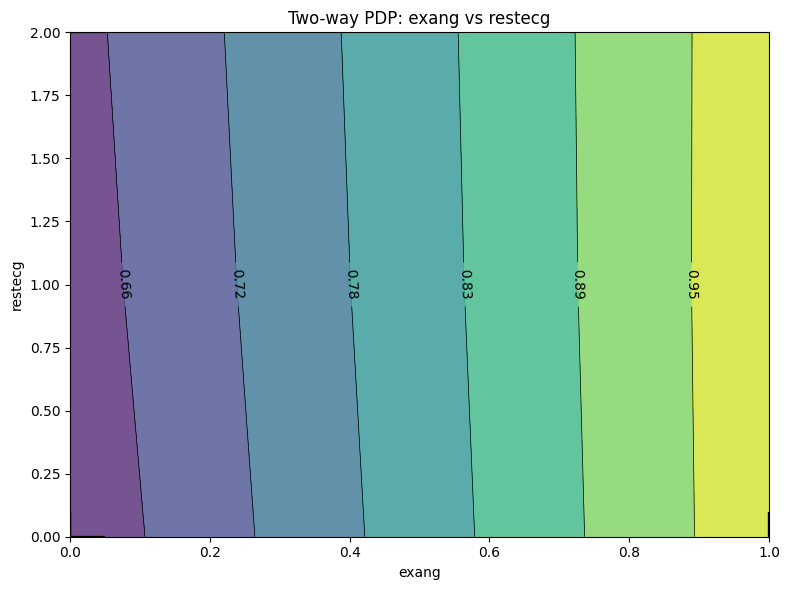

In [39]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair7,ax=ax)

ax.set_title("Two-way PDP: exang vs restecg")
plt.tight_layout() 
plt.show()

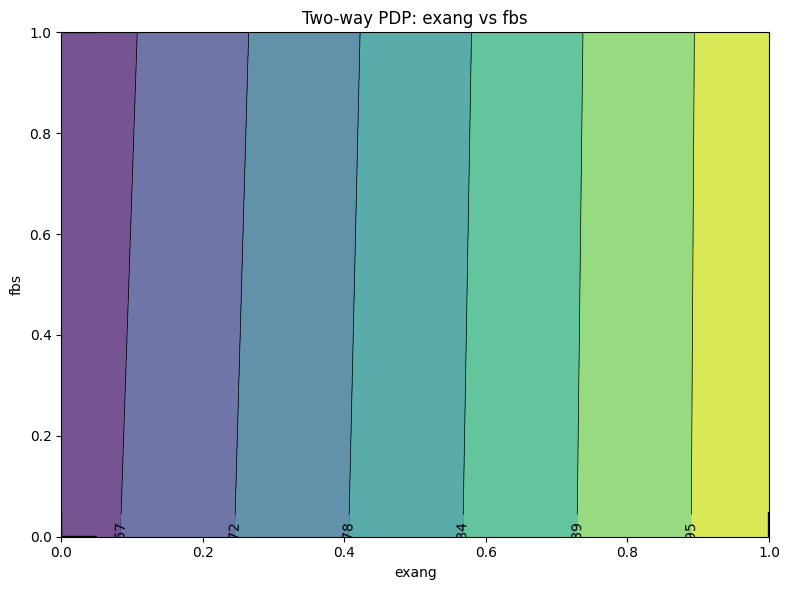

In [40]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair8,ax=ax)

ax.set_title("Two-way PDP: exang vs fbs")
plt.tight_layout() 
plt.show()

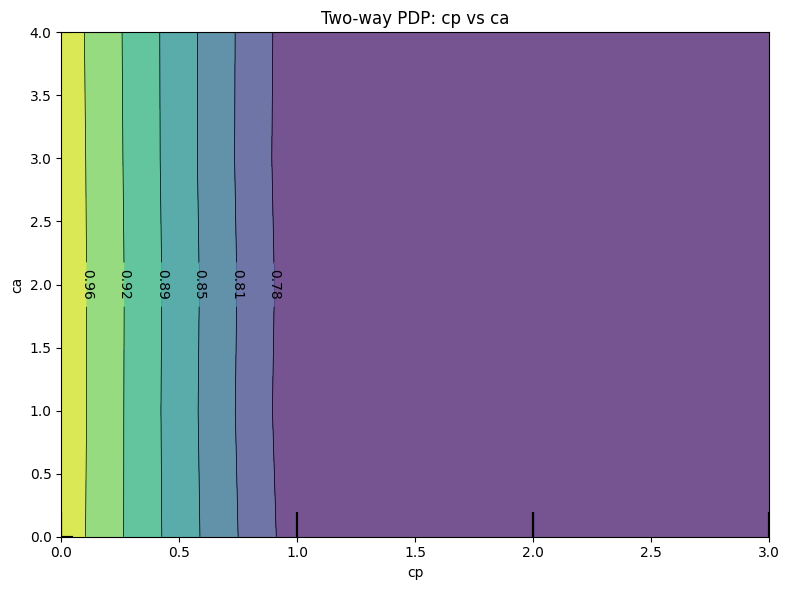

In [41]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair9,ax=ax)

ax.set_title("Two-way PDP: cp vs ca")
plt.tight_layout() 
plt.show()

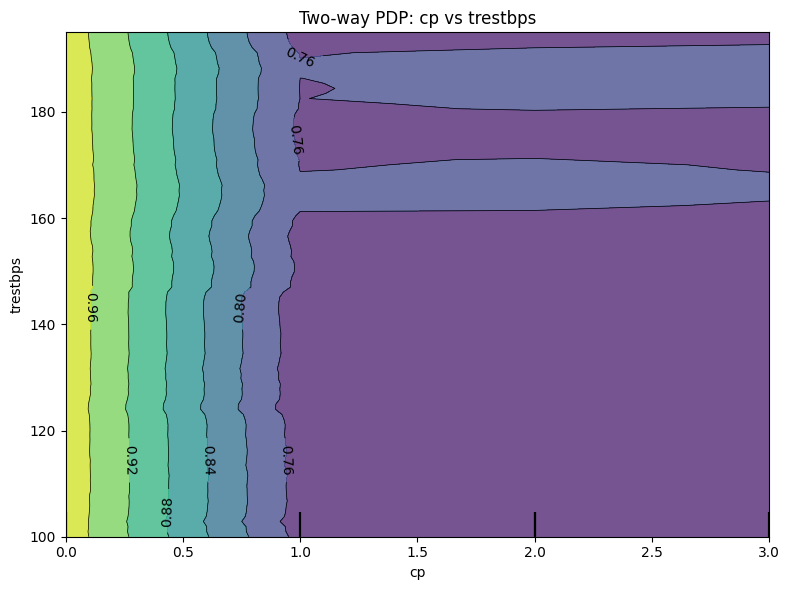

In [42]:
#RandomForest

fig, ax = plt.subplots(figsize=(8, 6)) 

# Generate the two-way PDP
PartialDependenceDisplay.from_estimator(perm_model3,X2,feature_pair10,ax=ax)

ax.set_title("Two-way PDP: cp vs trestbps")
plt.tight_layout() 
plt.show()

From the EDA above, it can be seen that exang and cp are important indicators of a patient with a heart disease.

# Baseline Model

In [43]:
X_baseline = data_train.copy()
y_baseline = X_baseline.pop("target")

In [44]:
X_baseline.shape

(7303, 14)

In [45]:
X_baseline = X_baseline.drop(['Id'], axis=1)

In [46]:
def evaluate_classifiers(X, y, classifiers, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    results = {name: [] for name in classifiers}

    # Perform Stratified K-Fold Cross-Validation for each model
    for model_name, model in classifiers.items():
        print(f"Training {model_name}...")

        # Reset the accuracy list for the current model
        fold_accuracies = []

        for train_index, val_index in skf.split(X, y):
            # Use .iloc to correctly access rows based on the indices provided by StratifiedKFold
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Train the model
            model.fit(X_train, y_train)

            # Predict on the validation fold
            predictions = model.predict(X_val)

            # Calculate and store the accuracy for the fold
            accuracy = accuracy_score(y_val, predictions)
            fold_accuracies.append(accuracy)

        # Store the fold accuracies for the current model
        results[model_name] = sum(fold_accuracies) / len(fold_accuracies)

    # Return results (average accuracy for each classifier)
    return results

In [47]:
# Define the classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(solver='saga', random_state=2),
    "SVC": SVC(kernel='linear', random_state=2),
    "XGBoost": xgb.XGBClassifier(random_state=2),
    "CatBoost": CatBoostClassifier(silent=True, random_state=2),
    "LightGBM": lgb.LGBMClassifier(random_state=2),
    "Naive Bayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=2),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = evaluate_classifiers(X_baseline, y_baseline, classifiers)
for model_name, avg_accuracy in results.items():
    print("=====================================================", end="\n\n")
    print(f"Average cross-validation accuracy for {model_name}: {avg_accuracy}")


Training Logistic Regression...
Training SVC...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 5346, number of negative: 1226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 6572, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.813451 -> initscore=1.472592
[LightGBM] [Info] Start training from score 1.472592
[LightGBM] [Info] Number of positive: 5347, number of negative: 1225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 6572, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pav

# Feature Engineering

In [48]:
train = data_train.copy()
test = data_test.copy()
bin_target = data_train['target']
train = train.drop(['Id','target'], axis=1)
train.head(2)

Age  Sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   33    0   1       158   205    1        0      154      0      1.5      1   
1   53    1   2       198   154    0        1      104      0      0.8      2   

   ca  thal  
0   4     1  
1   1     0

In [49]:
test=test.drop(['Id'],axis=1)
test.head(2)

Age  Sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   70    1   0       163   495    0        2      170      1      2.0      1   
1   61    1   0       131   238    0        2       74      1      4.9      2   

   ca  thal  
0   0     1  
1   2     2

In [50]:
# Join train and test df for unified preprocessing
df = pd.concat([train,test], sort=False)
df.head()

Age  Sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   33    0   1       158   205    1        0      154      0      1.5      1   
1   53    1   2       198   154    0        1      104      0      0.8      2   
2   37    1   2       101   202    1        0      155      0      2.1      1   
3   75    0   0       113   306    1        2       88      1      4.9      0   
4   35    1   2       139   419    1        1      166      1      0.9      2   

   ca  thal  
0   4     1  
1   1     0  
2   3     1  
3   2     2  
4   4     0

In [51]:
df.shape

(10000, 13)

From our EDA, we can see that all patients with exang value of one and cp value of zero all have heart diseases

In [52]:
#create binary indicators as new features
# Feature 1: exang == 1
# Feature 2: cp == 0
# Feature 3: exang == 1 and cp == 0

df['exang_1'] = (df['exang'] == 1).astype(int)  
df['cp_0'] = (df['cp'] == 0).astype(int)     
#==============================================================================================
df['bp_age_ratio'] = df['trestbps'] / df['Age']
df['angina_cp_interaction'] = df['exang'] * df['cp']
df['fbs_chol_interaction'] = df['fbs'] * df['chol']
df['age_chol_interaction'] = df['Age'] * df['chol']


In [53]:
#drop unimportant features
df = df.drop(['Age','Sex','thalach','slope','restecg'],axis=1)
df.head()

cp  trestbps  chol  fbs  exang  oldpeak  ca  thal  exang_1  cp_0  \
0   1       158   205    1      0      1.5   4     1        0     0   
1   2       198   154    0      0      0.8   1     0        0     0   
2   2       101   202    1      0      2.1   3     1        0     0   
3   0       113   306    1      1      4.9   2     2        1     1   
4   2       139   419    1      1      0.9   4     0        1     0   

   bp_age_ratio  angina_cp_interaction  fbs_chol_interaction  \
0      4.787879                      0                   205   
1      3.735849                      0                     0   
2      2.729730                      0                   202   
3      1.506667                      0                   306   
4      3.971429                      2                   419   

   age_chol_interaction  
0                  6765  
1                  8162  
2                  7474  
3                 22950  
4                 14665

In [61]:
# Split the combined data back into train and test data
Train = df.iloc[:len(bin_target), :]
Test = df.iloc[len(bin_target):, :]
print('Train Shape: ',Train.shape, end='\n\n')
print('Test Shape: ',Test.shape, end='\n\n')

Train Shape:  (7303, 14)

Test Shape:  (2697, 14)



In [62]:
# Define the classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(solver='saga', random_state=2),
    "SVC": SVC(kernel='linear', random_state=2),
    "XGBoost": xgb.XGBClassifier(random_state=2),
    "CatBoost": CatBoostClassifier(silent=True, random_state=2),
    "LightGBM": lgb.LGBMClassifier(random_state=2),
    "Naive Bayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=2),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

model_results = evaluate_classifiers(Train, bin_target, classifiers)
for model_name, avg_accuracy in model_results.items():
    print("=====================================================", end="\n\n")
    print(f"Average cross-validation accuracy for {model_name}: {avg_accuracy}")


Training Logistic Regression...
Training SVC...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 5346, number of negative: 1226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 6572, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.813451 -> initscore=1.472592
[LightGBM] [Info] Start training from score 1.472592
[LightGBM] [Info] Number of positive: 5347, number of negative: 1225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 6572, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: p

# HyperParameter Optimization

***Xgboost***

In [63]:
X_train, X_val, y_train, y_val = train_test_split(Train, bin_target, test_size=0.2, random_state=90)#90

In [64]:
X_val.shape

(1461, 14)

In [65]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1501, 10),
        'max_depth': trial.suggest_int('max_depth', 4, 11),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 60,
        'use_label_encoder': False,  # Prevents warnings in XGBoost
    }

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)

    # List to store accuracies for each fold
    fold_accuracies = []

    # Perform StratifiedKFold cross-validation
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        xgb_model = xgb.XGBClassifier(**params)
        xgb_model.fit(X_train_fold, y_train_fold)
        xgb_preds = xgb_model.predict(X_val_fold)
        
        accuracy = accuracy_score(y_val_fold, xgb_preds)
        fold_accuracies.append(accuracy)

    # Return the mean accuracy over the cross-validation folds
    return sum(fold_accuracies) / len(fold_accuracies)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print best trial
print("Best trial:")
xgb_trial = study.best_trial
print(f"Value: {xgb_trial.value}")
print("Best hyperparameters: ", xgb_trial.params)

[I 2024-10-14 15:26:15,840] A new study created in memory with name: no-name-d271f70f-77b1-4988-acd1-039e392b7794
[I 2024-10-14 15:26:25,391] Trial 0 finished with value: 0.8129050118940201 and parameters: {'n_estimators': 1100, 'max_depth': 6, 'learning_rate': 0.2708653097314988, 'subsample': 0.6614696444743542, 'colsample_bytree': 0.8677156612675403}. Best is trial 0 with value: 0.8129050118940201.
[I 2024-10-14 15:26:30,819] Trial 1 finished with value: 0.8079379401666333 and parameters: {'n_estimators': 920, 'max_depth': 4, 'learning_rate': 0.2580820846765269, 'subsample': 0.9360886438768603, 'colsample_bytree': 0.5756058648600768}. Best is trial 0 with value: 0.8129050118940201.
[I 2024-10-14 15:26:40,104] Trial 2 finished with value: 0.8098244313720894 and parameters: {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.20130232477204663, 'subsample': 0.7613299417568368, 'colsample_bytree': 0.694265209541072}. Best is trial 0 with value: 0.8129050118940201.
[I 2024-10-14 15:

Best trial:
Value: 0.8163284976036186
Best hyperparameters:  {'n_estimators': 1190, 'max_depth': 10, 'learning_rate': 0.11559160897076406, 'subsample': 0.8842156239538077, 'colsample_bytree': 0.8202255385642097}


***Logistic Regression***

In [66]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),  # Inverse of regularization strength
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

    # If penalty is 'none', ignore 'C' and 'l1_ratio'
    if params['penalty'] == 'none':
        params.pop('C')

    # Handle 'elasticnet' penalty: only saga solver can handle it, and it requires 'l1_ratio'
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
        params['solver'] = 'saga'
    else:
        params.pop('l1_ratio', None)

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # List to store accuracies for each fold
    fold_accuracies = []

    # Perform StratifiedKFold cross-validation
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Initialize Logistic Regression model with hyperparameters
        logreg_model = LogisticRegression(**params)

        # Train the model
        logreg_model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation set
        logreg_preds = logreg_model.predict(X_val_fold)

        # Calculate accuracy
        accuracy = accuracy_score(y_val_fold, logreg_preds)
        fold_accuracies.append(accuracy)

    # Return the mean accuracy over the cross-validation folds
    return sum(fold_accuracies) / len(fold_accuracies)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
logreg_trial = study.best_trial
print(f"Value: {logreg_trial.value}")
print("Best hyperparameters: ", logreg_trial.params)

[I 2024-10-14 15:45:21,284] A new study created in memory with name: no-name-c738c793-90a4-4e94-a1bf-b62610647a86
[I 2024-10-14 15:45:26,351] Trial 0 finished with value: 0.8183841709926526 and parameters: {'penalty': 'l1', 'C': 0.781569364650492, 'solver': 'saga', 'fit_intercept': True, 'max_iter': 576}. Best is trial 0 with value: 0.8183841709926526.
[I 2024-10-14 15:45:26,848] Trial 1 finished with value: 0.8153031510364789 and parameters: {'penalty': 'l2', 'C': 5.5721163233186415, 'solver': 'liblinear', 'fit_intercept': True, 'max_iter': 365}. Best is trial 0 with value: 0.8183841709926526.
[I 2024-10-14 15:45:27,339] Trial 2 finished with value: 0.8113650878282573 and parameters: {'penalty': 'l1', 'C': 6.660333708959941, 'solver': 'liblinear', 'fit_intercept': False, 'max_iter': 249}. Best is trial 0 with value: 0.8183841709926526.
[I 2024-10-14 15:45:34,418] Trial 3 finished with value: 0.8183841709926526 and parameters: {'penalty': 'l2', 'C': 0.0624199296976613, 'solver': 'saga'

Best trial:
Value: 0.8219805008378547
Best hyperparameters:  {'penalty': 'l2', 'C': 0.0061127763801209125, 'solver': 'liblinear', 'fit_intercept': True, 'max_iter': 636}


***KNN***

In [67]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),  # Number of neighbors to consider
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  # How to weight neighbors
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),  # Distance metric
        'p': trial.suggest_int('p', 1, 2),  # Power parameter for Minkowski distance
        'leaf_size': trial.suggest_int('leaf_size', 10, 50),  # Leaf size for tree-based algorithms
    }

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

    # List to store accuracies for each fold
    fold_accuracies = []

    # Perform StratifiedKFold cross-validation
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Initialize KNeighborsClassifier with hyperparameters
        knn_model = KNeighborsClassifier(**params)

        # Train the model
        knn_model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation set
        knn_preds = knn_model.predict(X_val_fold)

        # Calculate accuracy
        accuracy = accuracy_score(y_val_fold, knn_preds)
        fold_accuracies.append(accuracy)

    # Return the mean accuracy over the cross-validation folds
    return sum(fold_accuracies) / len(fold_accuracies)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
knn_trial = study.best_trial
print(f"Value: {knn_trial.value}")
print("Best hyperparameters: ", knn_trial.params)


[I 2024-10-14 15:50:41,835] A new study created in memory with name: no-name-21381f13-6b59-479f-983e-0bde46e7cd19
[I 2024-10-14 15:50:42,022] Trial 0 finished with value: 0.8176995324419654 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'leaf_size': 18}. Best is trial 0 with value: 0.8176995324419654.
[I 2024-10-14 15:50:42,509] Trial 1 finished with value: 0.8171864197241524 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 1, 'leaf_size': 43}. Best is trial 0 with value: 0.8176995324419654.
[I 2024-10-14 15:50:42,664] Trial 2 finished with value: 0.8165013417392221 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'leaf_size': 36}. Best is trial 0 with value: 0.8176995324419654.
[I 2024-10-14 15:50:43,185] Trial 3 finished with value: 0.8183841709926526 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'leaf_size': 19}. Best is 

Best trial:
Value: 0.8185552573912839
Best hyperparameters:  {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'leaf_size': 14}


***RandomForest***

In [68]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  
        'max_depth': trial.suggest_int('max_depth', 5, 50),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),  
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0) 
    }

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

    # List to store accuracies for each fold
    fold_accuracies = []

    # Perform StratifiedKFold cross-validation
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Initialize RandomForestClassifier with hyperparameters
        rf_model = RandomForestClassifier(**params)

        # Train the model
        rf_model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation set
        rf_preds = rf_model.predict(X_val_fold)

        # Calculate accuracy
        accuracy = accuracy_score(y_val_fold, rf_preds)
        fold_accuracies.append(accuracy)

    # Return the mean accuracy over the cross-validation folds
    return sum(fold_accuracies) / len(fold_accuracies)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
rf_trial = study.best_trial
print(f"Value: {rf_trial.value}")
print("Best hyperparameters: ", rf_trial.params)

[I 2024-10-14 15:52:10,405] A new study created in memory with name: no-name-8692458c-c41e-4333-a2b0-a98338c4475f
[I 2024-10-14 15:52:36,788] Trial 0 finished with value: 0.8069180132884914 and parameters: {'n_estimators': 951, 'max_depth': 13, 'min_samples_split': 14, 'max_features': 'log2', 'max_samples': 0.7236005501478429}. Best is trial 0 with value: 0.8069180132884914.
[I 2024-10-14 15:52:42,065] Trial 1 finished with value: 0.8165016346953842 and parameters: {'n_estimators': 226, 'max_depth': 5, 'min_samples_split': 19, 'max_features': 'sqrt', 'max_samples': 0.9060006103956688}. Best is trial 1 with value: 0.8165016346953842.
[I 2024-10-14 15:53:04,998] Trial 2 finished with value: 0.8069166949857622 and parameters: {'n_estimators': 804, 'max_depth': 14, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.7112130189582988}. Best is trial 1 with value: 0.8165016346953842.
[I 2024-10-14 15:53:14,197] Trial 3 finished with value: 0.8021226138720602 and parameters: {'n_

Best trial:
Value: 0.8178710582748397
Best hyperparameters:  {'n_estimators': 379, 'max_depth': 5, 'min_samples_split': 16, 'max_features': 'sqrt', 'max_samples': 0.5492063872183772}


In [70]:
xgb_best_params = xgb_trial.params
xgb_final_model = xgb.XGBClassifier(**xgb_best_params)
xgb_final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
xgb_model_pred = xgb_final_model.predict(X_val)
xgb_val_accuracy = accuracy_score(y_val, xgb_model_pred)
print(f"Val set accuracy: {xgb_val_accuracy}")

Val set accuracy: 0.811088295687885


In [71]:
knn_best_params = knn_trial.params
knn_final_model = KNeighborsClassifier(**knn_best_params)
knn_final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
knn_model_pred = knn_final_model.predict(X_val)
knn_val_accuracy = accuracy_score(y_val, knn_model_pred)
print(f"Val set accuracy: {knn_val_accuracy}")

Val set accuracy: 0.7939767282683093


In [72]:
logreg_best_params = logreg_trial.params
logreg_final_model = LogisticRegression(**logreg_best_params)
logreg_final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
logreg_model_pred = logreg_final_model.predict(X_val)
logreg_val_accuracy = accuracy_score(y_val, logreg_model_pred)
print(f"Val set accuracy: {logreg_val_accuracy}")

Val set accuracy: 0.7946611909650924


In [73]:
rf_best_params = rf_trial.params
rf_final_model = RandomForestClassifier(**rf_best_params)
rf_final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
rf_model_pred = rf_final_model.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, rf_model_pred)
print(f"Val set accuracy: {rf_val_accuracy}")

Val set accuracy: 0.7932922655715263


In [74]:
xgb_final_model_pred = xgb_final_model.predict(Test)

In [75]:
sub_sample.head()

Id
0  16501
1  10444
2  14288
3  10409
4  17330

In [76]:
# Make a copy of the submission sample
sub = sub_sample.copy()


# Display the first few rows of the updated DataFrame
xgb_sub = pd.DataFrame({'ID': sub['Id'], 'target': xgb_final_model_pred})
xgb_sub.head()

ID  target
0  16501       1
1  10444       1
2  14288       1
3  10409       1
4  17330       0

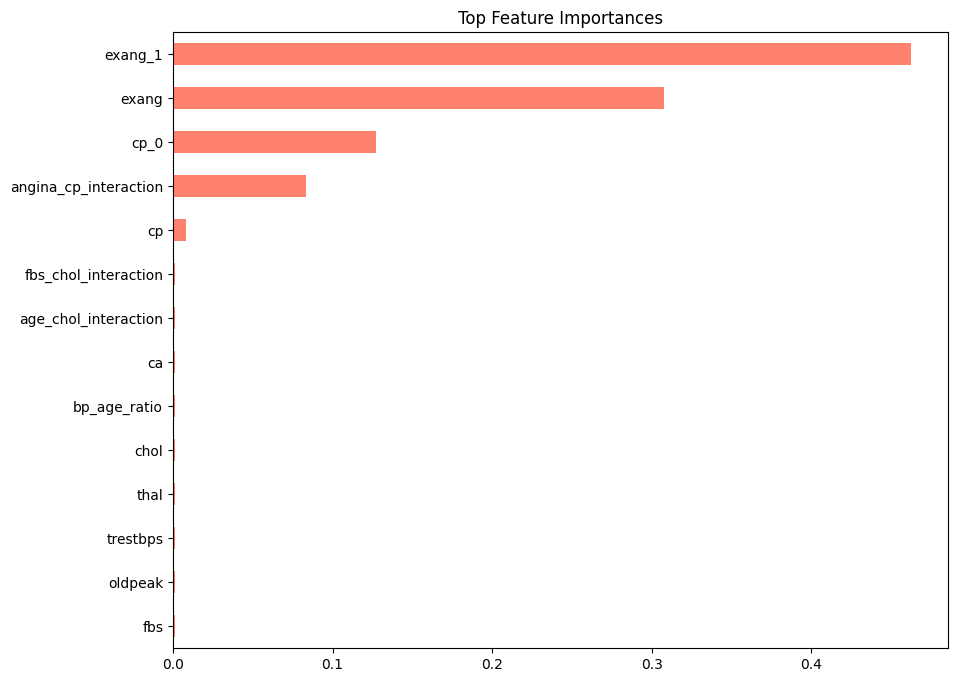

In [77]:
# Get the feature importances from the classifier
feature_importances = pd.Series(xgb_final_model.feature_importances_, index=X_train.columns)

top_features = feature_importances.sort_values(ascending=False)

top_features.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Top Feature Importances')
plt.show()